In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deepnewbie/flir-thermal-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1


In [3]:
# List files and folders in the dataset directory
import os

files = os.listdir(path)
print("Files and folders in dataset root:")
for f in files:
    print(f)

# Print all folders and subfolders recursively
print("\nAll folders and subfolders:")
for root, dirs, files in os.walk(path):
    print(f"Folder: {root}")
    for d in dirs:
        print(f"  Subfolder: ",d)

Files and folders in dataset root:
FLIR_ADAS_1_3

All folders and subfolders:
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1
  Subfolder:  FLIR_ADAS_1_3
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3
  Subfolder:  train
  Subfolder:  val
  Subfolder:  video
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train
  Subfolder:  Annotated_thermal_8_bit
  Subfolder:  RGB
  Subfolder:  thermal_16_bit
  Subfolder:  thermal_8_bit
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train\Annotated_thermal_8_bit
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train\RGB
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train\thermal

In [4]:
# Set RGB and thermal image directories for train and val splits
train_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "train", "RGB")
train_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "train", "thermal_8_bit")
val_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "RGB")
val_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "thermal_8_bit")

print("Train RGB directory:", train_rgb_dir)
print("Train Thermal directory:", train_thermal_dir)
print("Val RGB directory:", val_rgb_dir)
print("Val Thermal directory:", val_thermal_dir)

# Match images by filename prefix (without extension, ignoring extension differences)
def get_matched_files_by_prefix(rgb_dir, thermal_dir):
    rgb_files = [f for f in os.listdir(rgb_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    thermal_files = [f for f in os.listdir(thermal_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    rgb_prefix = {os.path.splitext(f)[0]: f for f in rgb_files}
    thermal_prefix = {os.path.splitext(f)[0]: f for f in thermal_files}
    common_prefixes = sorted(set(rgb_prefix.keys()) & set(thermal_prefix.keys()))
    matched_rgb = [rgb_prefix[p] for p in common_prefixes]
    matched_thermal = [thermal_prefix[p] for p in common_prefixes]
    return matched_rgb, matched_thermal, common_prefixes

matched_rgb, matched_thermal, matched_prefixes = get_matched_files_by_prefix(train_rgb_dir, train_thermal_dir)
val_matched_rgb, val_matched_thermal, val_matched_prefixes = get_matched_files_by_prefix(val_rgb_dir, val_thermal_dir)
print(f"Number of matched train RGB images: {len(matched_rgb)}")
print(f"Number of matched train thermal images: {len(matched_thermal)}")
print(f"Number of matched val RGB images: {len(val_matched_rgb)}")
print(f"Number of matched val thermal images: {len(val_matched_thermal)}")

Train RGB directory: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train\RGB
Train Thermal directory: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train\thermal_8_bit
Val RGB directory: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\val\RGB
Val Thermal directory: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\val\thermal_8_bit
Number of matched train RGB images: 8363
Number of matched train thermal images: 8363
Number of matched val RGB images: 1257
Number of matched val thermal images: 1257


In [5]:
# Define the custom dataset and U-Net model for RGB to thermal translation
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as T

class FLIRRGB2ThermalDataset(Dataset):
    def __init__(self, rgb_dir, thermal_dir, img_size=256, matched_rgb=None, matched_thermal=None):
        self.rgb_dir = rgb_dir
        self.thermal_dir = thermal_dir
        self.img_size = img_size
        # Use matched file lists if provided, else match by prefix
        if matched_rgb is not None and matched_thermal is not None:
            self.rgb_files = matched_rgb
            self.thermal_files = matched_thermal
        else:
            rgb_files = [f for f in os.listdir(rgb_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            thermal_files = [f for f in os.listdir(thermal_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            rgb_prefix = {os.path.splitext(f)[0]: f for f in rgb_files}
            thermal_prefix = {os.path.splitext(f)[0]: f for f in thermal_files}
            common_prefixes = sorted(set(rgb_prefix.keys()) & set(thermal_prefix.keys()))
            self.rgb_files = [rgb_prefix[p] for p in common_prefixes]
            self.thermal_files = [thermal_prefix[p] for p in common_prefixes]
        print(f"Paired {len(self.rgb_files)} RGB and thermal images.")
        if len(self.rgb_files) == 0:
            raise ValueError("No matching RGB and thermal image pairs found!")
        self.transform_rgb = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])
        self.transform_thermal = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.rgb_dir, self.rgb_files[idx])
        thermal_path = os.path.join(self.thermal_dir, self.thermal_files[idx])
        rgb = Image.open(rgb_path).convert('RGB')
        thermal = Image.open(thermal_path).convert('L')
        rgb = self.transform_rgb(rgb)
        thermal = self.transform_thermal(thermal)
        return rgb, thermal

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        for feature in features:
            self.downs.append(self.conv_block(in_channels, feature))
            in_channels = feature
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(self.conv_block(feature*2, feature))
        self.bottleneck = self.conv_block(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(2)(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = T.functional.resize(x, skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)
        return self.final_conv(x)

In [8]:
# Training loop for the U-Net model with diagnostics and quick test mode
def train_model(
    rgb_dir, thermal_dir, matched_rgb, matched_thermal, epochs=10, batch_size=8, lr=5e-4, img_size=256, save_path='unet_rgb2thermal.pth', max_samples=100
):
    import time
    from tqdm import tqdm

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = FLIRRGB2ThermalDataset(rgb_dir, thermal_dir, img_size, matched_rgb=matched_rgb, matched_thermal=matched_thermal)
    if max_samples is not None:
        indices = list(range(min(max_samples, len(dataset))))
        from torch.utils.data import Subset
        dataset = Subset(dataset, indices)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    model = UNet().to(device)
    criterion = nn.L1Loss()  # Try nn.MSELoss() for even smoother results
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        for i, (rgb, thermal) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
            rgb, thermal = rgb.to(device), thermal.to(device)
            pred = model(rgb)
            loss = criterion(pred, thermal)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * rgb.size(0)
            if (i+1) % 2 == 0:
                print(f"  Batch {i+1}/{len(loader)} - Batch Loss: {loss.item():.4f}")
        epoch_loss = running_loss / len(dataset)
        train_losses.append(epoch_loss)
        elapsed = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Time: {elapsed:.1f}s")
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
    print("Training complete. Best model saved.")
    return train_losses

# Example usage:
train_losses = train_model(train_rgb_dir, train_thermal_dir, matched_rgb, matched_thermal, epochs=10, batch_size=8, lr=5e-4, max_samples=100)

Paired 8363 RGB and thermal images.


Epoch 1:  15%|█▌        | 2/13 [00:45<04:14, 23.18s/it]

  Batch 2/13 - Batch Loss: 0.5009


Epoch 1:  31%|███       | 4/13 [01:31<03:29, 23.27s/it]

  Batch 4/13 - Batch Loss: 0.2759


Epoch 1:  46%|████▌     | 6/13 [02:37<03:22, 28.88s/it]

  Batch 6/13 - Batch Loss: 0.2324


Epoch 1:  62%|██████▏   | 8/13 [03:41<02:32, 30.51s/it]

  Batch 8/13 - Batch Loss: 0.1953


Epoch 1:  77%|███████▋  | 10/13 [04:44<01:33, 31.24s/it]

  Batch 10/13 - Batch Loss: 0.1685


Epoch 1:  92%|█████████▏| 12/13 [05:50<00:32, 32.17s/it]

  Batch 12/13 - Batch Loss: 0.1719


Epoch 1: 100%|██████████| 13/13 [06:07<00:00, 28.27s/it]


Epoch 1/10 - Loss: 0.2614 - Time: 367.5s


Epoch 2:  15%|█▌        | 2/13 [01:04<05:55, 32.31s/it]

  Batch 2/13 - Batch Loss: 0.1596


Epoch 2:  31%|███       | 4/13 [02:09<04:52, 32.47s/it]

  Batch 4/13 - Batch Loss: 0.1443


Epoch 2:  46%|████▌     | 6/13 [03:12<03:42, 31.85s/it]

  Batch 6/13 - Batch Loss: 0.1793


Epoch 2:  62%|██████▏   | 8/13 [04:16<02:39, 31.95s/it]

  Batch 8/13 - Batch Loss: 0.1414


Epoch 2:  77%|███████▋  | 10/13 [05:24<01:39, 33.18s/it]

  Batch 10/13 - Batch Loss: 0.1645


Epoch 2:  92%|█████████▏| 12/13 [06:34<00:34, 34.07s/it]

  Batch 12/13 - Batch Loss: 0.1465


Epoch 2: 100%|██████████| 13/13 [06:51<00:00, 31.65s/it]


Epoch 2/10 - Loss: 0.1555 - Time: 411.5s


Epoch 3:  15%|█▌        | 2/13 [01:08<06:14, 34.02s/it]

  Batch 2/13 - Batch Loss: 0.1750


Epoch 3:  31%|███       | 4/13 [02:16<05:07, 34.12s/it]

  Batch 4/13 - Batch Loss: 0.1324


Epoch 3:  46%|████▌     | 6/13 [03:06<03:16, 28.03s/it]

  Batch 6/13 - Batch Loss: 0.1416


Epoch 3:  62%|██████▏   | 8/13 [03:43<01:54, 22.92s/it]

  Batch 8/13 - Batch Loss: 0.1251


Epoch 3:  77%|███████▋  | 10/13 [04:23<01:03, 21.16s/it]

  Batch 10/13 - Batch Loss: 0.1158


Epoch 3:  92%|█████████▏| 12/13 [05:03<00:20, 20.68s/it]

  Batch 12/13 - Batch Loss: 0.1434


Epoch 3: 100%|██████████| 13/13 [05:13<00:00, 24.14s/it]


Epoch 3/10 - Loss: 0.1382 - Time: 313.8s


Epoch 4:  15%|█▌        | 2/13 [00:40<03:43, 20.36s/it]

  Batch 2/13 - Batch Loss: 0.1184


Epoch 4:  31%|███       | 4/13 [01:22<03:06, 20.69s/it]

  Batch 4/13 - Batch Loss: 0.1192


Epoch 4:  46%|████▌     | 6/13 [02:20<03:02, 26.11s/it]

  Batch 6/13 - Batch Loss: 0.1089


Epoch 4:  62%|██████▏   | 8/13 [03:31<02:35, 31.12s/it]

  Batch 8/13 - Batch Loss: 0.1379


Epoch 4:  77%|███████▋  | 10/13 [04:41<01:39, 33.21s/it]

  Batch 10/13 - Batch Loss: 0.1098


Epoch 4:  92%|█████████▏| 12/13 [05:52<00:34, 34.28s/it]

  Batch 12/13 - Batch Loss: 0.1088


Epoch 4: 100%|██████████| 13/13 [06:09<00:00, 28.45s/it]


Epoch 4/10 - Loss: 0.1202 - Time: 369.8s


Epoch 5:  15%|█▌        | 2/13 [01:11<06:35, 35.96s/it]

  Batch 2/13 - Batch Loss: 0.1075


Epoch 5:  31%|███       | 4/13 [02:23<05:22, 35.81s/it]

  Batch 4/13 - Batch Loss: 0.1183


Epoch 5:  46%|████▌     | 6/13 [03:35<04:11, 36.00s/it]

  Batch 6/13 - Batch Loss: 0.1019


Epoch 5:  62%|██████▏   | 8/13 [04:47<03:00, 36.03s/it]

  Batch 8/13 - Batch Loss: 0.1129


Epoch 5:  77%|███████▋  | 10/13 [05:59<01:48, 36.14s/it]

  Batch 10/13 - Batch Loss: 0.1213


Epoch 5:  92%|█████████▏| 12/13 [07:11<00:36, 36.02s/it]

  Batch 12/13 - Batch Loss: 0.1036


Epoch 5: 100%|██████████| 13/13 [07:29<00:00, 34.56s/it]


Epoch 5/10 - Loss: 0.1136 - Time: 449.3s


Epoch 6:  15%|█▌        | 2/13 [01:09<06:21, 34.71s/it]

  Batch 2/13 - Batch Loss: 0.1069


Epoch 6:  31%|███       | 4/13 [02:17<05:07, 34.20s/it]

  Batch 4/13 - Batch Loss: 0.0981


Epoch 6:  46%|████▌     | 6/13 [03:27<04:03, 34.76s/it]

  Batch 6/13 - Batch Loss: 0.1262


Epoch 6:  62%|██████▏   | 8/13 [04:38<02:56, 35.26s/it]

  Batch 8/13 - Batch Loss: 0.0890


Epoch 6:  77%|███████▋  | 10/13 [05:51<01:47, 35.76s/it]

  Batch 10/13 - Batch Loss: 0.1312


Epoch 6:  92%|█████████▏| 12/13 [07:02<00:35, 35.81s/it]

  Batch 12/13 - Batch Loss: 0.1024


Epoch 6: 100%|██████████| 13/13 [07:20<00:00, 33.90s/it]


Epoch 6/10 - Loss: 0.1095 - Time: 440.8s


Epoch 7:  15%|█▌        | 2/13 [01:11<06:33, 35.78s/it]

  Batch 2/13 - Batch Loss: 0.1141


Epoch 7:  31%|███       | 4/13 [02:22<05:21, 35.67s/it]

  Batch 4/13 - Batch Loss: 0.0952


Epoch 7:  46%|████▌     | 6/13 [03:33<04:08, 35.49s/it]

  Batch 6/13 - Batch Loss: 0.1122


Epoch 7:  62%|██████▏   | 8/13 [04:44<02:57, 35.60s/it]

  Batch 8/13 - Batch Loss: 0.0802


Epoch 7:  77%|███████▋  | 10/13 [05:56<01:47, 35.73s/it]

  Batch 10/13 - Batch Loss: 0.1336


Epoch 7:  92%|█████████▏| 12/13 [07:07<00:35, 35.75s/it]

  Batch 12/13 - Batch Loss: 0.1018


Epoch 7: 100%|██████████| 13/13 [07:25<00:00, 34.30s/it]


Epoch 7/10 - Loss: 0.1074 - Time: 446.0s


Epoch 8:  15%|█▌        | 2/13 [01:11<06:32, 35.65s/it]

  Batch 2/13 - Batch Loss: 0.1053


Epoch 8:  31%|███       | 4/13 [02:23<05:24, 36.00s/it]

  Batch 4/13 - Batch Loss: 0.1032


Epoch 8:  46%|████▌     | 6/13 [03:33<04:07, 35.35s/it]

  Batch 6/13 - Batch Loss: 0.0933


Epoch 8:  62%|██████▏   | 8/13 [04:44<02:58, 35.64s/it]

  Batch 8/13 - Batch Loss: 0.1058


Epoch 8:  77%|███████▋  | 10/13 [05:57<01:47, 35.95s/it]

  Batch 10/13 - Batch Loss: 0.1104


Epoch 8:  92%|█████████▏| 12/13 [07:07<00:35, 35.35s/it]

  Batch 12/13 - Batch Loss: 0.1220


Epoch 8: 100%|██████████| 13/13 [07:24<00:00, 34.20s/it]


Epoch 8/10 - Loss: 0.1069 - Time: 444.6s


Epoch 9:  15%|█▌        | 2/13 [01:12<06:38, 36.20s/it]

  Batch 2/13 - Batch Loss: 0.0849


Epoch 9:  31%|███       | 4/13 [02:24<05:24, 36.04s/it]

  Batch 4/13 - Batch Loss: 0.1193


Epoch 9:  46%|████▌     | 6/13 [03:36<04:12, 36.07s/it]

  Batch 6/13 - Batch Loss: 0.1114


Epoch 9:  62%|██████▏   | 8/13 [04:48<02:59, 35.94s/it]

  Batch 8/13 - Batch Loss: 0.1082


Epoch 9:  77%|███████▋  | 10/13 [05:59<01:46, 35.64s/it]

  Batch 10/13 - Batch Loss: 0.1053


Epoch 9:  92%|█████████▏| 12/13 [07:08<00:35, 35.18s/it]

  Batch 12/13 - Batch Loss: 0.1033


Epoch 9: 100%|██████████| 13/13 [07:27<00:00, 34.39s/it]


Epoch 9/10 - Loss: 0.1062 - Time: 447.1s


Epoch 10:  15%|█▌        | 2/13 [01:11<06:32, 35.68s/it]

  Batch 2/13 - Batch Loss: 0.1114


Epoch 10:  31%|███       | 4/13 [02:22<05:21, 35.73s/it]

  Batch 4/13 - Batch Loss: 0.1009


Epoch 10:  46%|████▌     | 6/13 [03:34<04:10, 35.85s/it]

  Batch 6/13 - Batch Loss: 0.1009


Epoch 10:  62%|██████▏   | 8/13 [04:46<02:58, 35.75s/it]

  Batch 8/13 - Batch Loss: 0.0982


Epoch 10:  77%|███████▋  | 10/13 [05:57<01:46, 35.64s/it]

  Batch 10/13 - Batch Loss: 0.1047


Epoch 10:  92%|█████████▏| 12/13 [07:08<00:35, 35.76s/it]

  Batch 12/13 - Batch Loss: 0.0974


Epoch 10: 100%|██████████| 13/13 [07:27<00:00, 34.41s/it]


Epoch 10/10 - Loss: 0.1058 - Time: 447.3s
Training complete. Best model saved.


In [ ]:
# Retrain the model from scratch
train_losses = train_model(
    train_rgb_dir,
    train_thermal_dir,
    matched_rgb,
    matched_thermal,
    epochs=10,         # You can increase epochs for better results
    batch_size=8,      # Adjust batch size as per your GPU/CPU memory
    lr=5e-4,           # Learning rate
    max_samples=None   # Use None to train on all available data
)

Paired 8363 RGB and thermal images.


Epoch 1:   0%|          | 2/1046 [00:26<3:58:13, 13.69s/it]

  Batch 2/1046 - Batch Loss: 0.4326


Epoch 1:   0%|          | 4/1046 [00:51<3:40:04, 12.67s/it]

  Batch 4/1046 - Batch Loss: 0.3363


Epoch 1:   1%|          | 6/1046 [01:15<3:32:52, 12.28s/it]

  Batch 6/1046 - Batch Loss: 0.2644


Epoch 1:   1%|          | 8/1046 [01:39<3:29:35, 12.12s/it]

  Batch 8/1046 - Batch Loss: 0.2414


Epoch 1:   1%|          | 10/1046 [02:03<3:27:59, 12.05s/it]

  Batch 10/1046 - Batch Loss: 0.2162


Epoch 1:   1%|          | 12/1046 [02:27<3:29:45, 12.17s/it]

  Batch 12/1046 - Batch Loss: 0.1680


Epoch 1:   1%|▏         | 14/1046 [02:51<3:27:22, 12.06s/it]

  Batch 14/1046 - Batch Loss: 0.1271


Epoch 1:   2%|▏         | 16/1046 [03:15<3:27:57, 12.11s/it]

  Batch 16/1046 - Batch Loss: 0.1713


Epoch 1:   2%|▏         | 18/1046 [03:40<3:28:17, 12.16s/it]

  Batch 18/1046 - Batch Loss: 0.1411


Epoch 1:   2%|▏         | 20/1046 [04:04<3:26:56, 12.10s/it]

  Batch 20/1046 - Batch Loss: 0.1617


Epoch 1:   2%|▏         | 22/1046 [04:31<3:37:41, 12.76s/it]

  Batch 22/1046 - Batch Loss: 0.1529


Epoch 1:   2%|▏         | 24/1046 [04:58<3:45:37, 13.25s/it]

  Batch 24/1046 - Batch Loss: 0.1589


Epoch 1:   2%|▏         | 26/1046 [05:25<3:46:03, 13.30s/it]

  Batch 26/1046 - Batch Loss: 0.1484


Epoch 1:   3%|▎         | 28/1046 [05:52<3:47:21, 13.40s/it]

  Batch 28/1046 - Batch Loss: 0.1540


Epoch 1:   3%|▎         | 30/1046 [06:19<3:48:13, 13.48s/it]

  Batch 30/1046 - Batch Loss: 0.1364


Epoch 1:   3%|▎         | 32/1046 [06:46<3:50:36, 13.65s/it]

  Batch 32/1046 - Batch Loss: 0.1277


Epoch 1:   3%|▎         | 34/1046 [07:13<3:48:12, 13.53s/it]

  Batch 34/1046 - Batch Loss: 0.1715


Epoch 1:   3%|▎         | 36/1046 [07:40<3:45:58, 13.42s/it]

  Batch 36/1046 - Batch Loss: 0.1270


Epoch 1:   4%|▎         | 38/1046 [08:07<3:47:01, 13.51s/it]

  Batch 38/1046 - Batch Loss: 0.1434


Epoch 1:   4%|▍         | 40/1046 [08:34<3:46:56, 13.53s/it]

  Batch 40/1046 - Batch Loss: 0.1496


Epoch 1:   4%|▍         | 42/1046 [09:01<3:47:48, 13.61s/it]

  Batch 42/1046 - Batch Loss: 0.1189


Epoch 1:   4%|▍         | 44/1046 [09:28<3:46:42, 13.58s/it]

  Batch 44/1046 - Batch Loss: 0.1234


Epoch 1:   4%|▍         | 46/1046 [09:56<3:46:05, 13.57s/it]

  Batch 46/1046 - Batch Loss: 0.1190


Epoch 1:   5%|▍         | 48/1046 [10:22<3:44:18, 13.49s/it]

  Batch 48/1046 - Batch Loss: 0.1563


Epoch 1:   5%|▍         | 50/1046 [10:50<3:45:05, 13.56s/it]

  Batch 50/1046 - Batch Loss: 0.1441


Epoch 1:   5%|▍         | 52/1046 [11:17<3:43:25, 13.49s/it]

  Batch 52/1046 - Batch Loss: 0.1633


Epoch 1:   5%|▌         | 54/1046 [11:43<3:41:50, 13.42s/it]

  Batch 54/1046 - Batch Loss: 0.1354


Epoch 1:   5%|▌         | 56/1046 [12:10<3:42:34, 13.49s/it]

  Batch 56/1046 - Batch Loss: 0.1587


Epoch 1:   6%|▌         | 58/1046 [12:37<3:41:01, 13.42s/it]

  Batch 58/1046 - Batch Loss: 0.1569


Epoch 1:   6%|▌         | 60/1046 [13:04<3:42:43, 13.55s/it]

  Batch 60/1046 - Batch Loss: 0.1581


Epoch 1:   6%|▌         | 62/1046 [13:32<3:43:15, 13.61s/it]

  Batch 62/1046 - Batch Loss: 0.1325


Epoch 1:   6%|▌         | 64/1046 [13:59<3:41:01, 13.50s/it]

  Batch 64/1046 - Batch Loss: 0.1358


Epoch 1:   6%|▋         | 66/1046 [14:26<3:41:36, 13.57s/it]

  Batch 66/1046 - Batch Loss: 0.1431


Epoch 1:   7%|▋         | 68/1046 [14:52<3:39:15, 13.45s/it]

  Batch 68/1046 - Batch Loss: 0.1428


Epoch 1:   7%|▋         | 70/1046 [15:19<3:39:07, 13.47s/it]

  Batch 70/1046 - Batch Loss: 0.1397


Epoch 1:   7%|▋         | 72/1046 [15:47<3:40:21, 13.57s/it]

  Batch 72/1046 - Batch Loss: 0.1264


Epoch 1:   7%|▋         | 74/1046 [16:14<3:41:09, 13.65s/it]

  Batch 74/1046 - Batch Loss: 0.1168


Epoch 1:   7%|▋         | 76/1046 [16:41<3:38:45, 13.53s/it]

  Batch 76/1046 - Batch Loss: 0.1577


Epoch 1:   7%|▋         | 78/1046 [17:08<3:39:26, 13.60s/it]

  Batch 78/1046 - Batch Loss: 0.1355


Epoch 1:   8%|▊         | 80/1046 [17:36<3:39:17, 13.62s/it]

  Batch 80/1046 - Batch Loss: 0.1469


Epoch 1:   8%|▊         | 82/1046 [18:03<3:38:24, 13.59s/it]

  Batch 82/1046 - Batch Loss: 0.1266


Epoch 1:   8%|▊         | 84/1046 [18:30<3:37:02, 13.54s/it]

  Batch 84/1046 - Batch Loss: 0.1170


Epoch 1:   8%|▊         | 86/1046 [18:57<3:37:06, 13.57s/it]

  Batch 86/1046 - Batch Loss: 0.1343


Epoch 1:   8%|▊         | 88/1046 [19:24<3:36:03, 13.53s/it]

  Batch 88/1046 - Batch Loss: 0.1299


Epoch 1:   9%|▊         | 90/1046 [19:51<3:36:05, 13.56s/it]

  Batch 90/1046 - Batch Loss: 0.1308


Epoch 1:   9%|▉         | 92/1046 [20:18<3:35:54, 13.58s/it]

  Batch 92/1046 - Batch Loss: 0.1233


Epoch 1:   9%|▉         | 94/1046 [20:45<3:33:39, 13.47s/it]

  Batch 94/1046 - Batch Loss: 0.1308


Epoch 1:   9%|▉         | 96/1046 [21:12<3:33:06, 13.46s/it]

  Batch 96/1046 - Batch Loss: 0.1134


Epoch 1:   9%|▉         | 98/1046 [21:38<3:30:25, 13.32s/it]

  Batch 98/1046 - Batch Loss: 0.1321


Epoch 1:  10%|▉         | 100/1046 [22:06<3:33:00, 13.51s/it]

  Batch 100/1046 - Batch Loss: 0.1057


Epoch 1:  10%|▉         | 102/1046 [22:32<3:32:28, 13.50s/it]

  Batch 102/1046 - Batch Loss: 0.1418


Epoch 1:  10%|▉         | 104/1046 [23:00<3:32:55, 13.56s/it]

  Batch 104/1046 - Batch Loss: 0.1156


Epoch 1:  10%|█         | 106/1046 [23:26<3:30:45, 13.45s/it]

  Batch 106/1046 - Batch Loss: 0.1262


Epoch 1:  10%|█         | 108/1046 [23:53<3:29:59, 13.43s/it]

  Batch 108/1046 - Batch Loss: 0.1326


Epoch 1:  11%|█         | 110/1046 [24:20<3:30:47, 13.51s/it]

  Batch 110/1046 - Batch Loss: 0.1169


Epoch 1:  11%|█         | 112/1046 [24:47<3:29:06, 13.43s/it]

  Batch 112/1046 - Batch Loss: 0.1193


Epoch 1:  11%|█         | 114/1046 [25:15<3:32:58, 13.71s/it]

  Batch 114/1046 - Batch Loss: 0.1140


Epoch 1:  11%|█         | 116/1046 [25:42<3:30:07, 13.56s/it]

  Batch 116/1046 - Batch Loss: 0.1373


Epoch 1:  11%|█▏        | 118/1046 [26:09<3:29:50, 13.57s/it]

  Batch 118/1046 - Batch Loss: 0.1357


Epoch 1:  11%|█▏        | 120/1046 [26:36<3:28:26, 13.51s/it]

  Batch 120/1046 - Batch Loss: 0.1204


Epoch 1:  12%|█▏        | 122/1046 [27:05<3:38:24, 14.18s/it]

  Batch 122/1046 - Batch Loss: 0.1320


Epoch 1:  12%|█▏        | 124/1046 [27:33<3:35:20, 14.01s/it]

  Batch 124/1046 - Batch Loss: 0.1139


Epoch 1:  12%|█▏        | 126/1046 [28:00<3:31:53, 13.82s/it]

  Batch 126/1046 - Batch Loss: 0.1232


Epoch 1:  12%|█▏        | 128/1046 [28:28<3:30:39, 13.77s/it]

  Batch 128/1046 - Batch Loss: 0.1259


Epoch 1:  12%|█▏        | 130/1046 [28:55<3:27:28, 13.59s/it]

  Batch 130/1046 - Batch Loss: 0.1178


Epoch 1:  13%|█▎        | 132/1046 [29:22<3:27:06, 13.60s/it]

  Batch 132/1046 - Batch Loss: 0.1494


Epoch 1:  13%|█▎        | 134/1046 [29:49<3:25:29, 13.52s/it]

  Batch 134/1046 - Batch Loss: 0.1343


Epoch 1:  13%|█▎        | 136/1046 [30:16<3:25:36, 13.56s/it]

  Batch 136/1046 - Batch Loss: 0.1116


Epoch 1:  13%|█▎        | 138/1046 [30:43<3:24:14, 13.50s/it]

  Batch 138/1046 - Batch Loss: 0.0977


Epoch 1:  13%|█▎        | 140/1046 [31:10<3:25:17, 13.60s/it]

  Batch 140/1046 - Batch Loss: 0.1391


Epoch 1:  14%|█▎        | 142/1046 [31:37<3:24:56, 13.60s/it]

  Batch 142/1046 - Batch Loss: 0.1288


Epoch 1:  14%|█▍        | 144/1046 [32:04<3:24:52, 13.63s/it]

  Batch 144/1046 - Batch Loss: 0.1200


Epoch 1:  14%|█▍        | 146/1046 [32:32<3:26:38, 13.78s/it]

  Batch 146/1046 - Batch Loss: 0.1162


Epoch 1:  14%|█▍        | 148/1046 [32:59<3:24:41, 13.68s/it]

  Batch 148/1046 - Batch Loss: 0.1140


Epoch 1:  14%|█▍        | 150/1046 [33:26<3:23:34, 13.63s/it]

  Batch 150/1046 - Batch Loss: 0.1073


Epoch 1:  15%|█▍        | 152/1046 [33:53<3:21:54, 13.55s/it]

  Batch 152/1046 - Batch Loss: 0.1084


Epoch 1:  15%|█▍        | 154/1046 [34:20<3:21:42, 13.57s/it]

  Batch 154/1046 - Batch Loss: 0.1022


Epoch 1:  15%|█▍        | 156/1046 [34:47<3:20:31, 13.52s/it]

  Batch 156/1046 - Batch Loss: 0.1361


Epoch 1:  15%|█▌        | 158/1046 [35:15<3:20:31, 13.55s/it]

  Batch 158/1046 - Batch Loss: 0.1235


Epoch 1:  15%|█▌        | 160/1046 [35:42<3:20:12, 13.56s/it]

  Batch 160/1046 - Batch Loss: 0.1516


Epoch 1:  15%|█▌        | 162/1046 [36:09<3:19:20, 13.53s/it]

  Batch 162/1046 - Batch Loss: 0.1242


Epoch 1:  16%|█▌        | 164/1046 [36:36<3:18:10, 13.48s/it]

  Batch 164/1046 - Batch Loss: 0.1310


Epoch 1:  16%|█▌        | 166/1046 [37:03<3:21:30, 13.74s/it]

  Batch 166/1046 - Batch Loss: 0.1053


Epoch 1:  16%|█▌        | 168/1046 [37:31<3:21:16, 13.75s/it]

  Batch 168/1046 - Batch Loss: 0.1063


Epoch 1:  16%|█▋        | 170/1046 [37:58<3:19:18, 13.65s/it]

  Batch 170/1046 - Batch Loss: 0.1254


Epoch 1:  16%|█▋        | 172/1046 [38:25<3:18:11, 13.61s/it]

  Batch 172/1046 - Batch Loss: 0.1087


Epoch 1:  17%|█▋        | 174/1046 [38:52<3:18:14, 13.64s/it]

  Batch 174/1046 - Batch Loss: 0.1179


Epoch 1:  17%|█▋        | 176/1046 [39:19<3:15:47, 13.50s/it]

  Batch 176/1046 - Batch Loss: 0.1488


Epoch 1:  17%|█▋        | 178/1046 [39:46<3:15:39, 13.52s/it]

  Batch 178/1046 - Batch Loss: 0.1231


Epoch 1:  17%|█▋        | 180/1046 [40:14<3:16:31, 13.62s/it]

  Batch 180/1046 - Batch Loss: 0.1026


Epoch 1:  17%|█▋        | 182/1046 [40:41<3:15:25, 13.57s/it]

  Batch 182/1046 - Batch Loss: 0.1036


Epoch 1:  18%|█▊        | 184/1046 [41:08<3:14:31, 13.54s/it]

  Batch 184/1046 - Batch Loss: 0.0900


Epoch 1:  18%|█▊        | 186/1046 [41:35<3:14:57, 13.60s/it]

  Batch 186/1046 - Batch Loss: 0.0923


Epoch 1:  18%|█▊        | 188/1046 [42:02<3:14:50, 13.63s/it]

  Batch 188/1046 - Batch Loss: 0.1109


Epoch 1:  18%|█▊        | 190/1046 [42:29<3:13:03, 13.53s/it]

  Batch 190/1046 - Batch Loss: 0.0923


Epoch 1:  18%|█▊        | 192/1046 [42:56<3:13:03, 13.56s/it]

  Batch 192/1046 - Batch Loss: 0.0961


Epoch 1:  19%|█▊        | 194/1046 [43:24<3:13:51, 13.65s/it]

  Batch 194/1046 - Batch Loss: 0.1067


Epoch 1:  19%|█▊        | 196/1046 [43:51<3:12:28, 13.59s/it]

  Batch 196/1046 - Batch Loss: 0.1042


Epoch 1:  19%|█▉        | 198/1046 [44:18<3:11:21, 13.54s/it]

  Batch 198/1046 - Batch Loss: 0.1146


Epoch 1:  19%|█▉        | 200/1046 [44:45<3:10:46, 13.53s/it]

  Batch 200/1046 - Batch Loss: 0.0941


Epoch 1:  19%|█▉        | 202/1046 [45:12<3:11:10, 13.59s/it]

  Batch 202/1046 - Batch Loss: 0.0897


Epoch 1:  20%|█▉        | 204/1046 [45:39<3:10:14, 13.56s/it]

  Batch 204/1046 - Batch Loss: 0.0978


Epoch 1:  20%|█▉        | 206/1046 [46:06<3:10:18, 13.59s/it]

  Batch 206/1046 - Batch Loss: 0.1111


Epoch 1:  20%|█▉        | 208/1046 [46:34<3:11:02, 13.68s/it]

  Batch 208/1046 - Batch Loss: 0.1081


Epoch 1:  20%|██        | 210/1046 [47:01<3:10:36, 13.68s/it]

  Batch 210/1046 - Batch Loss: 0.1055


Epoch 1:  20%|██        | 212/1046 [47:28<3:11:04, 13.75s/it]

  Batch 212/1046 - Batch Loss: 0.1247


Epoch 1:  20%|██        | 214/1046 [47:56<3:09:30, 13.67s/it]

  Batch 214/1046 - Batch Loss: 0.1087


Epoch 1:  21%|██        | 216/1046 [48:23<3:07:58, 13.59s/it]

  Batch 216/1046 - Batch Loss: 0.1252


Epoch 1:  21%|██        | 218/1046 [48:49<3:06:00, 13.48s/it]

  Batch 218/1046 - Batch Loss: 0.1068


Epoch 1:  21%|██        | 220/1046 [49:17<3:06:35, 13.55s/it]

  Batch 220/1046 - Batch Loss: 0.1112


Epoch 1:  21%|██        | 222/1046 [49:44<3:06:40, 13.59s/it]

  Batch 222/1046 - Batch Loss: 0.1043


Epoch 1:  21%|██▏       | 224/1046 [50:11<3:06:42, 13.63s/it]

  Batch 224/1046 - Batch Loss: 0.1168


Epoch 1:  22%|██▏       | 226/1046 [50:38<3:05:20, 13.56s/it]

  Batch 226/1046 - Batch Loss: 0.1309


Epoch 1:  22%|██▏       | 228/1046 [51:05<3:04:18, 13.52s/it]

  Batch 228/1046 - Batch Loss: 0.1167


Epoch 1:  22%|██▏       | 230/1046 [51:32<3:02:42, 13.43s/it]

  Batch 230/1046 - Batch Loss: 0.1161


Epoch 1:  22%|██▏       | 232/1046 [51:58<3:02:02, 13.42s/it]

  Batch 232/1046 - Batch Loss: 0.1129


Epoch 1:  22%|██▏       | 234/1046 [52:25<3:01:34, 13.42s/it]

  Batch 234/1046 - Batch Loss: 0.0877


Epoch 1:  23%|██▎       | 236/1046 [52:53<3:02:51, 13.55s/it]

  Batch 236/1046 - Batch Loss: 0.0968


Epoch 1:  23%|██▎       | 238/1046 [53:20<3:02:26, 13.55s/it]

  Batch 238/1046 - Batch Loss: 0.1159


Epoch 1:  23%|██▎       | 240/1046 [53:47<3:01:35, 13.52s/it]

  Batch 240/1046 - Batch Loss: 0.1028


Epoch 1:  23%|██▎       | 242/1046 [54:14<3:01:55, 13.58s/it]

  Batch 242/1046 - Batch Loss: 0.1142


Epoch 1:  23%|██▎       | 244/1046 [54:41<3:01:46, 13.60s/it]

  Batch 244/1046 - Batch Loss: 0.1125


Epoch 1:  24%|██▎       | 246/1046 [55:08<3:01:27, 13.61s/it]

  Batch 246/1046 - Batch Loss: 0.1007


Epoch 1:  24%|██▎       | 248/1046 [55:36<3:01:31, 13.65s/it]

  Batch 248/1046 - Batch Loss: 0.1209


Epoch 1:  24%|██▍       | 250/1046 [56:04<3:06:05, 14.03s/it]

  Batch 250/1046 - Batch Loss: 0.1074


Epoch 1:  24%|██▍       | 252/1046 [56:32<3:03:33, 13.87s/it]

  Batch 252/1046 - Batch Loss: 0.1015


Epoch 1:  24%|██▍       | 254/1046 [56:59<3:01:19, 13.74s/it]

  Batch 254/1046 - Batch Loss: 0.1105


Epoch 1:  24%|██▍       | 256/1046 [57:26<2:58:15, 13.54s/it]

  Batch 256/1046 - Batch Loss: 0.1081


Epoch 1:  25%|██▍       | 258/1046 [57:53<2:58:10, 13.57s/it]

  Batch 258/1046 - Batch Loss: 0.1121


Epoch 1:  25%|██▍       | 260/1046 [58:20<2:57:23, 13.54s/it]

  Batch 260/1046 - Batch Loss: 0.1117


Epoch 1:  25%|██▌       | 262/1046 [58:47<2:58:26, 13.66s/it]

  Batch 262/1046 - Batch Loss: 0.0949


Epoch 1:  25%|██▌       | 264/1046 [59:15<2:58:36, 13.70s/it]

  Batch 264/1046 - Batch Loss: 0.1101


Epoch 1:  25%|██▌       | 266/1046 [59:42<2:55:26, 13.50s/it]

  Batch 266/1046 - Batch Loss: 0.1154


Epoch 1:  26%|██▌       | 268/1046 [1:00:09<2:55:03, 13.50s/it]

  Batch 268/1046 - Batch Loss: 0.0977


Epoch 1:  26%|██▌       | 270/1046 [1:00:35<2:53:57, 13.45s/it]

  Batch 270/1046 - Batch Loss: 0.1033


Epoch 1:  26%|██▌       | 272/1046 [1:01:02<2:54:06, 13.50s/it]

  Batch 272/1046 - Batch Loss: 0.1128


Epoch 1:  26%|██▌       | 274/1046 [1:01:29<2:53:11, 13.46s/it]

  Batch 274/1046 - Batch Loss: 0.0912


Epoch 1:  26%|██▋       | 276/1046 [1:01:57<2:55:20, 13.66s/it]

  Batch 276/1046 - Batch Loss: 0.1032


Epoch 1:  27%|██▋       | 278/1046 [1:02:25<2:56:45, 13.81s/it]

  Batch 278/1046 - Batch Loss: 0.1039


Epoch 1:  27%|██▋       | 280/1046 [1:02:51<2:53:25, 13.58s/it]

  Batch 280/1046 - Batch Loss: 0.1088


Epoch 1:  27%|██▋       | 282/1046 [1:03:19<2:53:23, 13.62s/it]

  Batch 282/1046 - Batch Loss: 0.0994


Epoch 1:  27%|██▋       | 284/1046 [1:03:46<2:52:25, 13.58s/it]

  Batch 284/1046 - Batch Loss: 0.1073


Epoch 1:  27%|██▋       | 286/1046 [1:04:13<2:50:59, 13.50s/it]

  Batch 286/1046 - Batch Loss: 0.1494


Epoch 1:  28%|██▊       | 288/1046 [1:04:39<2:49:34, 13.42s/it]

  Batch 288/1046 - Batch Loss: 0.1076


Epoch 1:  28%|██▊       | 290/1046 [1:05:07<2:51:37, 13.62s/it]

  Batch 290/1046 - Batch Loss: 0.1008


Epoch 1:  28%|██▊       | 292/1046 [1:05:34<2:50:21, 13.56s/it]

  Batch 292/1046 - Batch Loss: 0.0958


Epoch 1:  28%|██▊       | 294/1046 [1:06:01<2:49:54, 13.56s/it]

  Batch 294/1046 - Batch Loss: 0.0931


Epoch 1:  28%|██▊       | 296/1046 [1:06:28<2:49:54, 13.59s/it]

  Batch 296/1046 - Batch Loss: 0.1163


Epoch 1:  28%|██▊       | 298/1046 [1:06:55<2:49:40, 13.61s/it]

  Batch 298/1046 - Batch Loss: 0.1190


Epoch 1:  29%|██▊       | 300/1046 [1:07:23<2:50:15, 13.69s/it]

  Batch 300/1046 - Batch Loss: 0.1099


Epoch 1:  29%|██▉       | 302/1046 [1:07:50<2:49:01, 13.63s/it]

  Batch 302/1046 - Batch Loss: 0.0903


Epoch 1:  29%|██▉       | 304/1046 [1:08:18<2:49:43, 13.72s/it]

  Batch 304/1046 - Batch Loss: 0.1048


Epoch 1:  29%|██▉       | 306/1046 [1:08:45<2:47:59, 13.62s/it]

  Batch 306/1046 - Batch Loss: 0.1088


Epoch 1:  29%|██▉       | 308/1046 [1:09:12<2:46:44, 13.56s/it]

  Batch 308/1046 - Batch Loss: 0.1069


Epoch 1:  30%|██▉       | 310/1046 [1:09:39<2:45:39, 13.51s/it]

  Batch 310/1046 - Batch Loss: 0.1118


Epoch 1:  30%|██▉       | 312/1046 [1:10:06<2:45:25, 13.52s/it]

  Batch 312/1046 - Batch Loss: 0.1056


Epoch 1:  30%|███       | 314/1046 [1:10:33<2:44:27, 13.48s/it]

  Batch 314/1046 - Batch Loss: 0.1187


Epoch 1:  30%|███       | 316/1046 [1:10:59<2:43:07, 13.41s/it]

  Batch 316/1046 - Batch Loss: 0.1320


Epoch 1:  30%|███       | 318/1046 [1:11:26<2:43:56, 13.51s/it]

  Batch 318/1046 - Batch Loss: 0.1111


Epoch 1:  31%|███       | 320/1046 [1:11:54<2:43:50, 13.54s/it]

  Batch 320/1046 - Batch Loss: 0.1110


Epoch 1:  31%|███       | 322/1046 [1:12:21<2:43:07, 13.52s/it]

  Batch 322/1046 - Batch Loss: 0.0953


Epoch 1:  31%|███       | 324/1046 [1:12:48<2:43:37, 13.60s/it]

  Batch 324/1046 - Batch Loss: 0.0963


Epoch 1:  31%|███       | 326/1046 [1:13:15<2:44:16, 13.69s/it]

  Batch 326/1046 - Batch Loss: 0.1118


Epoch 1:  31%|███▏      | 328/1046 [1:13:42<2:42:42, 13.60s/it]

  Batch 328/1046 - Batch Loss: 0.1072


Epoch 1:  32%|███▏      | 330/1046 [1:14:10<2:42:29, 13.62s/it]

  Batch 330/1046 - Batch Loss: 0.0901


Epoch 1:  32%|███▏      | 332/1046 [1:14:37<2:42:31, 13.66s/it]

  Batch 332/1046 - Batch Loss: 0.1110


Epoch 1:  32%|███▏      | 334/1046 [1:15:04<2:41:31, 13.61s/it]

  Batch 334/1046 - Batch Loss: 0.1024


Epoch 1:  32%|███▏      | 336/1046 [1:15:31<2:40:50, 13.59s/it]

  Batch 336/1046 - Batch Loss: 0.1101


Epoch 1:  32%|███▏      | 338/1046 [1:15:58<2:39:50, 13.55s/it]

  Batch 338/1046 - Batch Loss: 0.0893


Epoch 1:  33%|███▎      | 340/1046 [1:16:26<2:40:24, 13.63s/it]

  Batch 340/1046 - Batch Loss: 0.1043


Epoch 1:  33%|███▎      | 342/1046 [1:16:53<2:38:36, 13.52s/it]

  Batch 342/1046 - Batch Loss: 0.1218


Epoch 1:  33%|███▎      | 344/1046 [1:17:21<2:41:27, 13.80s/it]

  Batch 344/1046 - Batch Loss: 0.0987


Epoch 1:  33%|███▎      | 346/1046 [1:17:48<2:39:40, 13.69s/it]

  Batch 346/1046 - Batch Loss: 0.0958


Epoch 1:  33%|███▎      | 348/1046 [1:18:15<2:38:31, 13.63s/it]

  Batch 348/1046 - Batch Loss: 0.1065


Epoch 1:  33%|███▎      | 350/1046 [1:18:42<2:37:16, 13.56s/it]

  Batch 350/1046 - Batch Loss: 0.1112


Epoch 1:  34%|███▎      | 352/1046 [1:19:09<2:37:01, 13.58s/it]

  Batch 352/1046 - Batch Loss: 0.0832


Epoch 1:  34%|███▍      | 354/1046 [1:19:36<2:36:15, 13.55s/it]

  Batch 354/1046 - Batch Loss: 0.0942


Epoch 1:  34%|███▍      | 356/1046 [1:20:03<2:36:54, 13.64s/it]

  Batch 356/1046 - Batch Loss: 0.1091


Epoch 1:  34%|███▍      | 358/1046 [1:20:31<2:37:09, 13.71s/it]

  Batch 358/1046 - Batch Loss: 0.1011


Epoch 1:  34%|███▍      | 360/1046 [1:20:58<2:35:55, 13.64s/it]

  Batch 360/1046 - Batch Loss: 0.1154


Epoch 1:  35%|███▍      | 362/1046 [1:21:25<2:34:52, 13.59s/it]

  Batch 362/1046 - Batch Loss: 0.1055


Epoch 1:  35%|███▍      | 364/1046 [1:21:52<2:33:39, 13.52s/it]

  Batch 364/1046 - Batch Loss: 0.1011


Epoch 1:  35%|███▍      | 366/1046 [1:22:19<2:33:41, 13.56s/it]

  Batch 366/1046 - Batch Loss: 0.0965


Epoch 1:  35%|███▌      | 368/1046 [1:22:46<2:33:03, 13.54s/it]

  Batch 368/1046 - Batch Loss: 0.1115


Epoch 1:  35%|███▌      | 370/1046 [1:23:13<2:32:25, 13.53s/it]

  Batch 370/1046 - Batch Loss: 0.1022


Epoch 1:  36%|███▌      | 372/1046 [1:23:41<2:33:33, 13.67s/it]

  Batch 372/1046 - Batch Loss: 0.1138


Epoch 1:  36%|███▌      | 374/1046 [1:24:08<2:33:18, 13.69s/it]

  Batch 374/1046 - Batch Loss: 0.0953


Epoch 1:  36%|███▌      | 376/1046 [1:24:35<2:31:00, 13.52s/it]

  Batch 376/1046 - Batch Loss: 0.1104


Epoch 1:  36%|███▌      | 378/1046 [1:25:01<2:29:31, 13.43s/it]

  Batch 378/1046 - Batch Loss: 0.1152


Epoch 1:  36%|███▋      | 380/1046 [1:25:29<2:32:02, 13.70s/it]

  Batch 380/1046 - Batch Loss: 0.1080


Epoch 1:  37%|███▋      | 382/1046 [1:25:57<2:30:41, 13.62s/it]

  Batch 382/1046 - Batch Loss: 0.1485


Epoch 1:  37%|███▋      | 384/1046 [1:26:23<2:29:37, 13.56s/it]

  Batch 384/1046 - Batch Loss: 0.0992


Epoch 1:  37%|███▋      | 386/1046 [1:26:51<2:28:59, 13.55s/it]

  Batch 386/1046 - Batch Loss: 0.1093


Epoch 1:  37%|███▋      | 388/1046 [1:27:19<2:30:40, 13.74s/it]

  Batch 388/1046 - Batch Loss: 0.0933


Epoch 1:  37%|███▋      | 390/1046 [1:27:46<2:28:37, 13.59s/it]

  Batch 390/1046 - Batch Loss: 0.0931


Epoch 1:  37%|███▋      | 392/1046 [1:28:13<2:28:18, 13.61s/it]

  Batch 392/1046 - Batch Loss: 0.1015


Epoch 1:  38%|███▊      | 394/1046 [1:28:40<2:27:24, 13.57s/it]

  Batch 394/1046 - Batch Loss: 0.0943


Epoch 1:  38%|███▊      | 396/1046 [1:29:07<2:27:20, 13.60s/it]

  Batch 396/1046 - Batch Loss: 0.1099


Epoch 1:  38%|███▊      | 398/1046 [1:29:34<2:25:48, 13.50s/it]

  Batch 398/1046 - Batch Loss: 0.0960


Epoch 1:  38%|███▊      | 400/1046 [1:30:01<2:26:43, 13.63s/it]

  Batch 400/1046 - Batch Loss: 0.1116


Epoch 1:  38%|███▊      | 402/1046 [1:30:28<2:25:41, 13.57s/it]

  Batch 402/1046 - Batch Loss: 0.1006


Epoch 1:  39%|███▊      | 404/1046 [1:30:55<2:25:11, 13.57s/it]

  Batch 404/1046 - Batch Loss: 0.0941


Epoch 1:  39%|███▉      | 406/1046 [1:31:22<2:24:14, 13.52s/it]

  Batch 406/1046 - Batch Loss: 0.0903


Epoch 1:  39%|███▉      | 408/1046 [1:31:49<2:23:06, 13.46s/it]

  Batch 408/1046 - Batch Loss: 0.0958


Epoch 1:  39%|███▉      | 410/1046 [1:32:17<2:24:32, 13.64s/it]

  Batch 410/1046 - Batch Loss: 0.1003


Epoch 1:  39%|███▉      | 412/1046 [1:32:44<2:24:43, 13.70s/it]

  Batch 412/1046 - Batch Loss: 0.1111


Epoch 1:  40%|███▉      | 414/1046 [1:33:11<2:23:16, 13.60s/it]

  Batch 414/1046 - Batch Loss: 0.1462


Epoch 1:  40%|███▉      | 416/1046 [1:33:38<2:22:11, 13.54s/it]

  Batch 416/1046 - Batch Loss: 0.1128


Epoch 1:  40%|███▉      | 418/1046 [1:34:05<2:22:37, 13.63s/it]

  Batch 418/1046 - Batch Loss: 0.0988


Epoch 1:  40%|████      | 420/1046 [1:34:32<2:21:46, 13.59s/it]

  Batch 420/1046 - Batch Loss: 0.0958


Epoch 1:  40%|████      | 422/1046 [1:35:00<2:21:02, 13.56s/it]

  Batch 422/1046 - Batch Loss: 0.0954


Epoch 1:  41%|████      | 424/1046 [1:35:27<2:20:54, 13.59s/it]

  Batch 424/1046 - Batch Loss: 0.1213


Epoch 1:  41%|████      | 426/1046 [1:35:54<2:20:48, 13.63s/it]

  Batch 426/1046 - Batch Loss: 0.1087


Epoch 1:  41%|████      | 428/1046 [1:36:21<2:19:41, 13.56s/it]

  Batch 428/1046 - Batch Loss: 0.1153


Epoch 1:  41%|████      | 430/1046 [1:36:48<2:19:07, 13.55s/it]

  Batch 430/1046 - Batch Loss: 0.0846


Epoch 1:  41%|████▏     | 432/1046 [1:37:16<2:20:00, 13.68s/it]

  Batch 432/1046 - Batch Loss: 0.0826


Epoch 1:  41%|████▏     | 434/1046 [1:37:43<2:18:25, 13.57s/it]

  Batch 434/1046 - Batch Loss: 0.1039


Epoch 1:  42%|████▏     | 436/1046 [1:38:10<2:18:03, 13.58s/it]

  Batch 436/1046 - Batch Loss: 0.0895


Epoch 1:  42%|████▏     | 438/1046 [1:38:37<2:17:45, 13.59s/it]

  Batch 438/1046 - Batch Loss: 0.1156


Epoch 1:  42%|████▏     | 440/1046 [1:39:04<2:18:22, 13.70s/it]

  Batch 440/1046 - Batch Loss: 0.1275


Epoch 1:  42%|████▏     | 442/1046 [1:39:32<2:17:14, 13.63s/it]

  Batch 442/1046 - Batch Loss: 0.0864


Epoch 1:  42%|████▏     | 444/1046 [1:39:59<2:16:19, 13.59s/it]

  Batch 444/1046 - Batch Loss: 0.1082


Epoch 1:  43%|████▎     | 446/1046 [1:40:26<2:16:20, 13.63s/it]

  Batch 446/1046 - Batch Loss: 0.1014


Epoch 1:  43%|████▎     | 448/1046 [1:40:53<2:15:19, 13.58s/it]

  Batch 448/1046 - Batch Loss: 0.1134


Epoch 1:  43%|████▎     | 450/1046 [1:41:20<2:15:04, 13.60s/it]

  Batch 450/1046 - Batch Loss: 0.0938


Epoch 1:  43%|████▎     | 452/1046 [1:41:47<2:13:29, 13.48s/it]

  Batch 452/1046 - Batch Loss: 0.0961


Epoch 1:  43%|████▎     | 454/1046 [1:42:15<2:14:42, 13.65s/it]

  Batch 454/1046 - Batch Loss: 0.1062


Epoch 1:  44%|████▎     | 456/1046 [1:42:42<2:13:49, 13.61s/it]

  Batch 456/1046 - Batch Loss: 0.0874


Epoch 1:  44%|████▍     | 458/1046 [1:43:10<2:16:41, 13.95s/it]

  Batch 458/1046 - Batch Loss: 0.1134


Epoch 1:  44%|████▍     | 460/1046 [1:43:37<2:14:23, 13.76s/it]

  Batch 460/1046 - Batch Loss: 0.0995


Epoch 1:  44%|████▍     | 462/1046 [1:44:05<2:13:03, 13.67s/it]

  Batch 462/1046 - Batch Loss: 0.1163


Epoch 1:  44%|████▍     | 464/1046 [1:44:32<2:11:55, 13.60s/it]

  Batch 464/1046 - Batch Loss: 0.1109


Epoch 1:  45%|████▍     | 466/1046 [1:44:59<2:12:37, 13.72s/it]

  Batch 466/1046 - Batch Loss: 0.1140


Epoch 1:  45%|████▍     | 468/1046 [1:45:26<2:11:42, 13.67s/it]

  Batch 468/1046 - Batch Loss: 0.1072


Epoch 1:  45%|████▍     | 470/1046 [1:45:53<2:10:14, 13.57s/it]

  Batch 470/1046 - Batch Loss: 0.1308


Epoch 1:  45%|████▌     | 472/1046 [1:46:20<2:09:42, 13.56s/it]

  Batch 472/1046 - Batch Loss: 0.1018


Epoch 1:  45%|████▌     | 474/1046 [1:46:47<2:08:59, 13.53s/it]

  Batch 474/1046 - Batch Loss: 0.1000


Epoch 1:  46%|████▌     | 476/1046 [1:47:15<2:10:01, 13.69s/it]

  Batch 476/1046 - Batch Loss: 0.1103


Epoch 1:  46%|████▌     | 478/1046 [1:47:43<2:10:04, 13.74s/it]

  Batch 478/1046 - Batch Loss: 0.0976


Epoch 1:  46%|████▌     | 480/1046 [1:48:10<2:10:18, 13.81s/it]

  Batch 480/1046 - Batch Loss: 0.1063


Epoch 1:  46%|████▌     | 482/1046 [1:48:38<2:08:43, 13.70s/it]

  Batch 482/1046 - Batch Loss: 0.1313


Epoch 1:  46%|████▋     | 484/1046 [1:49:05<2:08:24, 13.71s/it]

  Batch 484/1046 - Batch Loss: 0.1113


Epoch 1:  46%|████▋     | 486/1046 [1:49:32<2:06:34, 13.56s/it]

  Batch 486/1046 - Batch Loss: 0.1070


Epoch 1:  47%|████▋     | 488/1046 [1:49:59<2:05:31, 13.50s/it]

  Batch 488/1046 - Batch Loss: 0.0960


Epoch 1:  47%|████▋     | 490/1046 [1:50:26<2:05:57, 13.59s/it]

  Batch 490/1046 - Batch Loss: 0.0973


Epoch 1:  47%|████▋     | 492/1046 [1:50:53<2:04:59, 13.54s/it]

  Batch 492/1046 - Batch Loss: 0.1140


Epoch 1:  47%|████▋     | 494/1046 [1:51:21<2:05:45, 13.67s/it]

  Batch 494/1046 - Batch Loss: 0.0924


Epoch 1:  47%|████▋     | 496/1046 [1:51:47<2:03:39, 13.49s/it]

  Batch 496/1046 - Batch Loss: 0.1042


Epoch 1:  48%|████▊     | 498/1046 [1:52:14<2:02:29, 13.41s/it]

  Batch 498/1046 - Batch Loss: 0.0911


Epoch 1:  48%|████▊     | 500/1046 [1:52:41<2:02:30, 13.46s/it]

  Batch 500/1046 - Batch Loss: 0.0812


Epoch 1:  48%|████▊     | 502/1046 [1:53:08<2:02:35, 13.52s/it]

  Batch 502/1046 - Batch Loss: 0.0992


Epoch 1:  48%|████▊     | 504/1046 [1:53:35<2:01:55, 13.50s/it]

  Batch 504/1046 - Batch Loss: 0.1100


Epoch 1:  48%|████▊     | 506/1046 [1:54:02<2:01:20, 13.48s/it]

  Batch 506/1046 - Batch Loss: 0.0917


Epoch 1:  49%|████▊     | 508/1046 [1:54:29<2:01:59, 13.60s/it]

  Batch 508/1046 - Batch Loss: 0.1046


Epoch 1:  49%|████▉     | 510/1046 [1:54:57<2:01:18, 13.58s/it]

  Batch 510/1046 - Batch Loss: 0.0908


Epoch 1:  49%|████▉     | 512/1046 [1:55:24<2:01:48, 13.69s/it]

  Batch 512/1046 - Batch Loss: 0.1063


Epoch 1:  49%|████▉     | 514/1046 [1:55:51<2:00:22, 13.58s/it]

  Batch 514/1046 - Batch Loss: 0.0911


Epoch 1:  49%|████▉     | 516/1046 [1:56:18<2:00:08, 13.60s/it]

  Batch 516/1046 - Batch Loss: 0.1031


Epoch 1:  50%|████▉     | 518/1046 [1:56:47<2:02:27, 13.92s/it]

  Batch 518/1046 - Batch Loss: 0.1205


Epoch 1:  50%|████▉     | 520/1046 [1:57:14<2:00:37, 13.76s/it]

  Batch 520/1046 - Batch Loss: 0.1246


Epoch 1:  50%|████▉     | 522/1046 [1:57:41<1:59:39, 13.70s/it]

  Batch 522/1046 - Batch Loss: 0.1222


Epoch 1:  50%|█████     | 524/1046 [1:58:08<1:58:42, 13.64s/it]

  Batch 524/1046 - Batch Loss: 0.1249


Epoch 1:  50%|█████     | 526/1046 [1:58:35<1:57:41, 13.58s/it]

  Batch 526/1046 - Batch Loss: 0.0982


Epoch 1:  50%|█████     | 528/1046 [1:59:02<1:56:35, 13.50s/it]

  Batch 528/1046 - Batch Loss: 0.0852


Epoch 1:  51%|█████     | 530/1046 [1:59:29<1:56:00, 13.49s/it]

  Batch 530/1046 - Batch Loss: 0.1188


Epoch 1:  51%|█████     | 532/1046 [1:59:56<1:55:31, 13.49s/it]

  Batch 532/1046 - Batch Loss: 0.1129


Epoch 1:  51%|█████     | 534/1046 [2:00:24<1:56:18, 13.63s/it]

  Batch 534/1046 - Batch Loss: 0.0920


Epoch 1:  51%|█████     | 536/1046 [2:00:51<1:55:11, 13.55s/it]

  Batch 536/1046 - Batch Loss: 0.0959


Epoch 1:  51%|█████▏    | 538/1046 [2:01:18<1:55:01, 13.59s/it]

  Batch 538/1046 - Batch Loss: 0.0876


Epoch 1:  52%|█████▏    | 540/1046 [2:01:45<1:54:51, 13.62s/it]

  Batch 540/1046 - Batch Loss: 0.1061


Epoch 1:  52%|█████▏    | 542/1046 [2:02:12<1:54:28, 13.63s/it]

  Batch 542/1046 - Batch Loss: 0.1032


Epoch 1:  52%|█████▏    | 544/1046 [2:02:39<1:53:36, 13.58s/it]

  Batch 544/1046 - Batch Loss: 0.1099


Epoch 1:  52%|█████▏    | 546/1046 [2:03:06<1:52:58, 13.56s/it]

  Batch 546/1046 - Batch Loss: 0.1137


Epoch 1:  52%|█████▏    | 548/1046 [2:03:34<1:52:53, 13.60s/it]

  Batch 548/1046 - Batch Loss: 0.0940


Epoch 1:  53%|█████▎    | 550/1046 [2:04:01<1:52:05, 13.56s/it]

  Batch 550/1046 - Batch Loss: 0.1019


Epoch 1:  53%|█████▎    | 552/1046 [2:04:28<1:51:41, 13.57s/it]

  Batch 552/1046 - Batch Loss: 0.0927


Epoch 1:  53%|█████▎    | 554/1046 [2:04:55<1:50:42, 13.50s/it]

  Batch 554/1046 - Batch Loss: 0.1082


Epoch 1:  53%|█████▎    | 556/1046 [2:05:22<1:50:26, 13.52s/it]

  Batch 556/1046 - Batch Loss: 0.0987


Epoch 1:  53%|█████▎    | 558/1046 [2:05:49<1:49:41, 13.49s/it]

  Batch 558/1046 - Batch Loss: 0.0979


Epoch 1:  54%|█████▎    | 560/1046 [2:06:16<1:50:10, 13.60s/it]

  Batch 560/1046 - Batch Loss: 0.1051


Epoch 1:  54%|█████▎    | 562/1046 [2:06:43<1:50:02, 13.64s/it]

  Batch 562/1046 - Batch Loss: 0.0919


Epoch 1:  54%|█████▍    | 564/1046 [2:07:10<1:49:36, 13.64s/it]

  Batch 564/1046 - Batch Loss: 0.0916


Epoch 1:  54%|█████▍    | 566/1046 [2:07:38<1:49:03, 13.63s/it]

  Batch 566/1046 - Batch Loss: 0.0884


Epoch 1:  54%|█████▍    | 568/1046 [2:08:05<1:47:59, 13.56s/it]

  Batch 568/1046 - Batch Loss: 0.0872


Epoch 1:  54%|█████▍    | 570/1046 [2:08:32<1:47:43, 13.58s/it]

  Batch 570/1046 - Batch Loss: 0.1047


Epoch 1:  55%|█████▍    | 572/1046 [2:08:59<1:46:42, 13.51s/it]

  Batch 572/1046 - Batch Loss: 0.0974


Epoch 1:  55%|█████▍    | 574/1046 [2:09:26<1:46:47, 13.58s/it]

  Batch 574/1046 - Batch Loss: 0.0987


Epoch 1:  55%|█████▌    | 576/1046 [2:09:53<1:46:01, 13.54s/it]

  Batch 576/1046 - Batch Loss: 0.1029


Epoch 1:  55%|█████▌    | 578/1046 [2:10:20<1:45:45, 13.56s/it]

  Batch 578/1046 - Batch Loss: 0.0921


Epoch 1:  55%|█████▌    | 580/1046 [2:10:47<1:44:57, 13.51s/it]

  Batch 580/1046 - Batch Loss: 0.0927


Epoch 1:  56%|█████▌    | 582/1046 [2:11:14<1:44:28, 13.51s/it]

  Batch 582/1046 - Batch Loss: 0.0843


Epoch 1:  56%|█████▌    | 584/1046 [2:11:41<1:44:26, 13.56s/it]

  Batch 584/1046 - Batch Loss: 0.0915


Epoch 1:  56%|█████▌    | 586/1046 [2:12:08<1:43:38, 13.52s/it]

  Batch 586/1046 - Batch Loss: 0.1000


Epoch 1:  56%|█████▌    | 588/1046 [2:12:35<1:42:03, 13.37s/it]

  Batch 588/1046 - Batch Loss: 0.0893


Epoch 1:  56%|█████▋    | 590/1046 [2:13:02<1:41:56, 13.41s/it]

  Batch 590/1046 - Batch Loss: 0.0905


Epoch 1:  57%|█████▋    | 592/1046 [2:13:29<1:41:37, 13.43s/it]

  Batch 592/1046 - Batch Loss: 0.1040


Epoch 1:  57%|█████▋    | 594/1046 [2:13:56<1:41:45, 13.51s/it]

  Batch 594/1046 - Batch Loss: 0.0813


Epoch 1:  57%|█████▋    | 596/1046 [2:14:23<1:41:00, 13.47s/it]

  Batch 596/1046 - Batch Loss: 0.0932


Epoch 1:  57%|█████▋    | 598/1046 [2:14:50<1:40:35, 13.47s/it]

  Batch 598/1046 - Batch Loss: 0.1069


Epoch 1:  57%|█████▋    | 600/1046 [2:15:17<1:40:11, 13.48s/it]

  Batch 600/1046 - Batch Loss: 0.0965


Epoch 1:  58%|█████▊    | 602/1046 [2:15:43<1:39:33, 13.45s/it]

  Batch 602/1046 - Batch Loss: 0.0921


Epoch 1:  58%|█████▊    | 604/1046 [2:16:11<1:40:11, 13.60s/it]

  Batch 604/1046 - Batch Loss: 0.0940


Epoch 1:  58%|█████▊    | 606/1046 [2:16:38<1:39:32, 13.57s/it]

  Batch 606/1046 - Batch Loss: 0.0988


Epoch 1:  58%|█████▊    | 608/1046 [2:17:05<1:39:32, 13.64s/it]

  Batch 608/1046 - Batch Loss: 0.1048


Epoch 1:  58%|█████▊    | 610/1046 [2:17:32<1:38:50, 13.60s/it]

  Batch 610/1046 - Batch Loss: 0.1034


Epoch 1:  59%|█████▊    | 612/1046 [2:18:00<1:38:29, 13.62s/it]

  Batch 612/1046 - Batch Loss: 0.0939


Epoch 1:  59%|█████▊    | 614/1046 [2:18:27<1:37:52, 13.59s/it]

  Batch 614/1046 - Batch Loss: 0.0917


Epoch 1:  59%|█████▉    | 616/1046 [2:18:54<1:37:25, 13.59s/it]

  Batch 616/1046 - Batch Loss: 0.1002


Epoch 1:  59%|█████▉    | 618/1046 [2:19:21<1:36:39, 13.55s/it]

  Batch 618/1046 - Batch Loss: 0.1140


Epoch 1:  59%|█████▉    | 620/1046 [2:19:48<1:36:01, 13.52s/it]

  Batch 620/1046 - Batch Loss: 0.1008


Epoch 1:  59%|█████▉    | 622/1046 [2:20:15<1:35:42, 13.54s/it]

  Batch 622/1046 - Batch Loss: 0.1018


Epoch 1:  60%|█████▉    | 624/1046 [2:20:42<1:35:29, 13.58s/it]

  Batch 624/1046 - Batch Loss: 0.0981


Epoch 1:  60%|█████▉    | 626/1046 [2:21:10<1:35:26, 13.63s/it]

  Batch 626/1046 - Batch Loss: 0.1032


Epoch 1:  60%|██████    | 628/1046 [2:21:37<1:34:31, 13.57s/it]

  Batch 628/1046 - Batch Loss: 0.0959


Epoch 1:  60%|██████    | 630/1046 [2:22:04<1:33:57, 13.55s/it]

  Batch 630/1046 - Batch Loss: 0.0941


Epoch 1:  60%|██████    | 632/1046 [2:22:31<1:33:03, 13.49s/it]

  Batch 632/1046 - Batch Loss: 0.1123


Epoch 1:  61%|██████    | 634/1046 [2:22:57<1:32:24, 13.46s/it]

  Batch 634/1046 - Batch Loss: 0.0993


Epoch 1:  61%|██████    | 636/1046 [2:23:24<1:32:08, 13.48s/it]

  Batch 636/1046 - Batch Loss: 0.0914


Epoch 1:  61%|██████    | 638/1046 [2:23:51<1:31:39, 13.48s/it]

  Batch 638/1046 - Batch Loss: 0.0876


Epoch 1:  61%|██████    | 640/1046 [2:24:19<1:31:47, 13.57s/it]

  Batch 640/1046 - Batch Loss: 0.1055


Epoch 1:  61%|██████▏   | 642/1046 [2:24:46<1:31:17, 13.56s/it]

  Batch 642/1046 - Batch Loss: 0.1171


Epoch 1:  62%|██████▏   | 644/1046 [2:25:14<1:32:19, 13.78s/it]

  Batch 644/1046 - Batch Loss: 0.1076


Epoch 1:  62%|██████▏   | 646/1046 [2:25:41<1:31:53, 13.78s/it]

  Batch 646/1046 - Batch Loss: 0.0986


Epoch 1:  62%|██████▏   | 648/1046 [2:26:08<1:30:20, 13.62s/it]

  Batch 648/1046 - Batch Loss: 0.1010


Epoch 1:  62%|██████▏   | 650/1046 [2:26:35<1:29:39, 13.59s/it]

  Batch 650/1046 - Batch Loss: 0.1102


Epoch 1:  62%|██████▏   | 652/1046 [2:27:03<1:30:01, 13.71s/it]

  Batch 652/1046 - Batch Loss: 0.0924


Epoch 1:  63%|██████▎   | 654/1046 [2:27:30<1:29:27, 13.69s/it]

  Batch 654/1046 - Batch Loss: 0.0966


Epoch 1:  63%|██████▎   | 656/1046 [2:27:57<1:28:59, 13.69s/it]

  Batch 656/1046 - Batch Loss: 0.0968


Epoch 1:  63%|██████▎   | 658/1046 [2:28:25<1:28:32, 13.69s/it]

  Batch 658/1046 - Batch Loss: 0.0935


Epoch 1:  63%|██████▎   | 660/1046 [2:28:52<1:27:20, 13.58s/it]

  Batch 660/1046 - Batch Loss: 0.1018


Epoch 1:  63%|██████▎   | 662/1046 [2:29:19<1:27:01, 13.60s/it]

  Batch 662/1046 - Batch Loss: 0.0996


Epoch 1:  63%|██████▎   | 664/1046 [2:29:46<1:25:56, 13.50s/it]

  Batch 664/1046 - Batch Loss: 0.1018


Epoch 1:  64%|██████▎   | 666/1046 [2:30:13<1:25:43, 13.54s/it]

  Batch 666/1046 - Batch Loss: 0.1062


Epoch 1:  64%|██████▍   | 668/1046 [2:30:40<1:25:09, 13.52s/it]

  Batch 668/1046 - Batch Loss: 0.1128


Epoch 1:  64%|██████▍   | 670/1046 [2:31:07<1:25:02, 13.57s/it]

  Batch 670/1046 - Batch Loss: 0.1068


Epoch 1:  64%|██████▍   | 672/1046 [2:31:34<1:24:00, 13.48s/it]

  Batch 672/1046 - Batch Loss: 0.0969


Epoch 1:  64%|██████▍   | 674/1046 [2:32:01<1:23:42, 13.50s/it]

  Batch 674/1046 - Batch Loss: 0.1065


Epoch 1:  65%|██████▍   | 676/1046 [2:32:28<1:24:00, 13.62s/it]

  Batch 676/1046 - Batch Loss: 0.1087


Epoch 1:  65%|██████▍   | 678/1046 [2:32:55<1:23:01, 13.54s/it]

  Batch 678/1046 - Batch Loss: 0.0874


Epoch 1:  65%|██████▌   | 680/1046 [2:33:22<1:22:04, 13.45s/it]

  Batch 680/1046 - Batch Loss: 0.1047


Epoch 1:  65%|██████▌   | 682/1046 [2:33:49<1:21:45, 13.48s/it]

  Batch 682/1046 - Batch Loss: 0.0967


Epoch 1:  65%|██████▌   | 684/1046 [2:34:16<1:22:12, 13.62s/it]

  Batch 684/1046 - Batch Loss: 0.0924


Epoch 1:  66%|██████▌   | 686/1046 [2:34:44<1:21:45, 13.63s/it]

  Batch 686/1046 - Batch Loss: 0.0869


Epoch 1:  66%|██████▌   | 688/1046 [2:35:11<1:21:16, 13.62s/it]

  Batch 688/1046 - Batch Loss: 0.1000


Epoch 1:  66%|██████▌   | 690/1046 [2:35:38<1:20:50, 13.63s/it]

  Batch 690/1046 - Batch Loss: 0.1007


Epoch 1:  66%|██████▌   | 692/1046 [2:36:05<1:19:28, 13.47s/it]

  Batch 692/1046 - Batch Loss: 0.0996


Epoch 1:  66%|██████▋   | 694/1046 [2:36:31<1:18:43, 13.42s/it]

  Batch 694/1046 - Batch Loss: 0.1246


Epoch 1:  67%|██████▋   | 696/1046 [2:36:58<1:18:36, 13.47s/it]

  Batch 696/1046 - Batch Loss: 0.1045


Epoch 1:  67%|██████▋   | 698/1046 [2:37:26<1:18:53, 13.60s/it]

  Batch 698/1046 - Batch Loss: 0.0891


Epoch 1:  67%|██████▋   | 700/1046 [2:37:53<1:18:07, 13.55s/it]

  Batch 700/1046 - Batch Loss: 0.0937


Epoch 1:  67%|██████▋   | 702/1046 [2:38:20<1:18:07, 13.63s/it]

  Batch 702/1046 - Batch Loss: 0.0897


Epoch 1:  67%|██████▋   | 704/1046 [2:38:47<1:17:14, 13.55s/it]

  Batch 704/1046 - Batch Loss: 0.0926


Epoch 1:  67%|██████▋   | 706/1046 [2:39:14<1:16:33, 13.51s/it]

  Batch 706/1046 - Batch Loss: 0.0708


Epoch 1:  68%|██████▊   | 708/1046 [2:39:41<1:16:03, 13.50s/it]

  Batch 708/1046 - Batch Loss: 0.0875


Epoch 1:  68%|██████▊   | 710/1046 [2:40:08<1:16:04, 13.58s/it]

  Batch 710/1046 - Batch Loss: 0.0823


Epoch 1:  68%|██████▊   | 712/1046 [2:40:35<1:15:44, 13.61s/it]

  Batch 712/1046 - Batch Loss: 0.0969


Epoch 1:  68%|██████▊   | 714/1046 [2:41:02<1:14:54, 13.54s/it]

  Batch 714/1046 - Batch Loss: 0.1019


Epoch 1:  68%|██████▊   | 716/1046 [2:41:29<1:14:29, 13.54s/it]

  Batch 716/1046 - Batch Loss: 0.0991


Epoch 1:  69%|██████▊   | 718/1046 [2:41:56<1:13:47, 13.50s/it]

  Batch 718/1046 - Batch Loss: 0.0961


Epoch 1:  69%|██████▉   | 720/1046 [2:42:23<1:13:45, 13.58s/it]

  Batch 720/1046 - Batch Loss: 0.0953


Epoch 1:  69%|██████▉   | 722/1046 [2:42:50<1:13:04, 13.53s/it]

  Batch 722/1046 - Batch Loss: 0.1113


Epoch 1:  69%|██████▉   | 724/1046 [2:43:18<1:13:12, 13.64s/it]

  Batch 724/1046 - Batch Loss: 0.1011


Epoch 1:  69%|██████▉   | 726/1046 [2:43:45<1:12:35, 13.61s/it]

  Batch 726/1046 - Batch Loss: 0.0961


Epoch 1:  70%|██████▉   | 728/1046 [2:44:12<1:11:44, 13.54s/it]

  Batch 728/1046 - Batch Loss: 0.1086


Epoch 1:  70%|██████▉   | 730/1046 [2:44:39<1:11:07, 13.51s/it]

  Batch 730/1046 - Batch Loss: 0.1054


Epoch 1:  70%|██████▉   | 732/1046 [2:45:06<1:10:28, 13.47s/it]

  Batch 732/1046 - Batch Loss: 0.0862


Epoch 1:  70%|███████   | 734/1046 [2:45:32<1:09:48, 13.42s/it]

  Batch 734/1046 - Batch Loss: 0.0926


Epoch 1:  70%|███████   | 736/1046 [2:45:59<1:08:59, 13.35s/it]

  Batch 736/1046 - Batch Loss: 0.1197


Epoch 1:  71%|███████   | 738/1046 [2:46:25<1:08:07, 13.27s/it]

  Batch 738/1046 - Batch Loss: 0.1264


Epoch 1:  71%|███████   | 740/1046 [2:46:52<1:08:11, 13.37s/it]

  Batch 740/1046 - Batch Loss: 0.0920


Epoch 1:  71%|███████   | 742/1046 [2:47:20<1:08:44, 13.57s/it]

  Batch 742/1046 - Batch Loss: 0.0970


Epoch 1:  71%|███████   | 744/1046 [2:47:47<1:08:10, 13.55s/it]

  Batch 744/1046 - Batch Loss: 0.0814


Epoch 1:  71%|███████▏  | 746/1046 [2:48:14<1:07:28, 13.50s/it]

  Batch 746/1046 - Batch Loss: 0.0878


Epoch 1:  72%|███████▏  | 748/1046 [2:48:41<1:07:10, 13.52s/it]

  Batch 748/1046 - Batch Loss: 0.0994


Epoch 1:  72%|███████▏  | 750/1046 [2:49:08<1:06:44, 13.53s/it]

  Batch 750/1046 - Batch Loss: 0.0827


Epoch 1:  72%|███████▏  | 752/1046 [2:49:35<1:06:02, 13.48s/it]

  Batch 752/1046 - Batch Loss: 0.1134


Epoch 1:  72%|███████▏  | 754/1046 [2:50:02<1:05:44, 13.51s/it]

  Batch 754/1046 - Batch Loss: 0.1006


Epoch 1:  72%|███████▏  | 756/1046 [2:50:29<1:05:32, 13.56s/it]

  Batch 756/1046 - Batch Loss: 0.1014


Epoch 1:  72%|███████▏  | 758/1046 [2:50:56<1:05:11, 13.58s/it]

  Batch 758/1046 - Batch Loss: 0.0725


Epoch 1:  73%|███████▎  | 760/1046 [2:51:23<1:04:47, 13.59s/it]

  Batch 760/1046 - Batch Loss: 0.0880


Epoch 1:  73%|███████▎  | 762/1046 [2:51:51<1:04:15, 13.58s/it]

  Batch 762/1046 - Batch Loss: 0.1046


Epoch 1:  73%|███████▎  | 764/1046 [2:52:18<1:03:51, 13.59s/it]

  Batch 764/1046 - Batch Loss: 0.0856


Epoch 1:  73%|███████▎  | 766/1046 [2:52:45<1:03:32, 13.62s/it]

  Batch 766/1046 - Batch Loss: 0.0900


Epoch 1:  73%|███████▎  | 768/1046 [2:53:12<1:03:05, 13.62s/it]

  Batch 768/1046 - Batch Loss: 0.1189


Epoch 1:  74%|███████▎  | 770/1046 [2:53:39<1:02:36, 13.61s/it]

  Batch 770/1046 - Batch Loss: 0.0908


Epoch 1:  74%|███████▍  | 772/1046 [2:54:06<1:02:13, 13.62s/it]

  Batch 772/1046 - Batch Loss: 0.1016


Epoch 1:  74%|███████▍  | 774/1046 [2:54:34<1:01:41, 13.61s/it]

  Batch 774/1046 - Batch Loss: 0.0921


Epoch 1:  74%|███████▍  | 776/1046 [2:55:01<1:01:02, 13.56s/it]

  Batch 776/1046 - Batch Loss: 0.1130


Epoch 1:  74%|███████▍  | 778/1046 [2:55:28<1:00:50, 13.62s/it]

  Batch 778/1046 - Batch Loss: 0.0957


Epoch 1:  75%|███████▍  | 780/1046 [2:55:56<1:01:15, 13.82s/it]

  Batch 780/1046 - Batch Loss: 0.1449


Epoch 1:  75%|███████▍  | 782/1046 [2:56:23<59:58, 13.63s/it]  

  Batch 782/1046 - Batch Loss: 0.1133


Epoch 1:  75%|███████▍  | 784/1046 [2:56:50<1:00:02, 13.75s/it]

  Batch 784/1046 - Batch Loss: 0.1098


Epoch 1:  75%|███████▌  | 786/1046 [2:57:18<59:05, 13.64s/it]  

  Batch 786/1046 - Batch Loss: 0.0870


Epoch 1:  75%|███████▌  | 788/1046 [2:57:44<58:18, 13.56s/it]

  Batch 788/1046 - Batch Loss: 0.1015


Epoch 1:  76%|███████▌  | 790/1046 [2:58:12<58:00, 13.60s/it]

  Batch 790/1046 - Batch Loss: 0.0995


Epoch 1:  76%|███████▌  | 792/1046 [2:58:39<57:15, 13.53s/it]

  Batch 792/1046 - Batch Loss: 0.0853


Epoch 1:  76%|███████▌  | 794/1046 [2:59:06<57:14, 13.63s/it]

  Batch 794/1046 - Batch Loss: 0.0994


Epoch 1:  76%|███████▌  | 796/1046 [2:59:33<56:46, 13.62s/it]

  Batch 796/1046 - Batch Loss: 0.0819


Epoch 1:  76%|███████▋  | 798/1046 [3:00:01<56:23, 13.64s/it]

  Batch 798/1046 - Batch Loss: 0.1201


Epoch 1:  76%|███████▋  | 800/1046 [3:00:28<55:36, 13.56s/it]

  Batch 800/1046 - Batch Loss: 0.1438


Epoch 1:  77%|███████▋  | 802/1046 [3:00:54<54:52, 13.49s/it]

  Batch 802/1046 - Batch Loss: 0.0833


Epoch 1:  77%|███████▋  | 804/1046 [3:01:22<54:37, 13.54s/it]

  Batch 804/1046 - Batch Loss: 0.1102


Epoch 1:  77%|███████▋  | 806/1046 [3:01:48<53:50, 13.46s/it]

  Batch 806/1046 - Batch Loss: 0.0998


Epoch 1:  77%|███████▋  | 808/1046 [3:02:16<54:06, 13.64s/it]

  Batch 808/1046 - Batch Loss: 0.0858


Epoch 1:  77%|███████▋  | 810/1046 [3:02:43<53:39, 13.64s/it]

  Batch 810/1046 - Batch Loss: 0.1249


Epoch 1:  78%|███████▊  | 812/1046 [3:03:11<53:16, 13.66s/it]

  Batch 812/1046 - Batch Loss: 0.0968


Epoch 1:  78%|███████▊  | 814/1046 [3:03:37<52:11, 13.50s/it]

  Batch 814/1046 - Batch Loss: 0.0990


Epoch 1:  78%|███████▊  | 816/1046 [3:04:04<51:20, 13.39s/it]

  Batch 816/1046 - Batch Loss: 0.1052


Epoch 1:  78%|███████▊  | 818/1046 [3:04:31<51:11, 13.47s/it]

  Batch 818/1046 - Batch Loss: 0.0784


Epoch 1:  78%|███████▊  | 820/1046 [3:04:58<50:51, 13.50s/it]

  Batch 820/1046 - Batch Loss: 0.0978


Epoch 1:  79%|███████▊  | 822/1046 [3:05:25<50:49, 13.61s/it]

  Batch 822/1046 - Batch Loss: 0.1090


Epoch 1:  79%|███████▉  | 824/1046 [3:05:53<50:28, 13.64s/it]

  Batch 824/1046 - Batch Loss: 0.0927


Epoch 1:  79%|███████▉  | 826/1046 [3:06:20<49:46, 13.57s/it]

  Batch 826/1046 - Batch Loss: 0.1069


Epoch 1:  79%|███████▉  | 828/1046 [3:06:47<49:19, 13.58s/it]

  Batch 828/1046 - Batch Loss: 0.0831


Epoch 1:  79%|███████▉  | 830/1046 [3:07:14<49:03, 13.63s/it]

  Batch 830/1046 - Batch Loss: 0.0803


Epoch 1:  80%|███████▉  | 832/1046 [3:07:41<48:19, 13.55s/it]

  Batch 832/1046 - Batch Loss: 0.0808


Epoch 1:  80%|███████▉  | 834/1046 [3:08:09<48:22, 13.69s/it]

  Batch 834/1046 - Batch Loss: 0.1057


Epoch 1:  80%|███████▉  | 836/1046 [3:08:36<47:24, 13.55s/it]

  Batch 836/1046 - Batch Loss: 0.0803


Epoch 1:  80%|████████  | 838/1046 [3:09:03<46:58, 13.55s/it]

  Batch 838/1046 - Batch Loss: 0.0809


Epoch 1:  80%|████████  | 840/1046 [3:09:30<46:38, 13.58s/it]

  Batch 840/1046 - Batch Loss: 0.1115


Epoch 1:  80%|████████  | 842/1046 [3:09:57<45:41, 13.44s/it]

  Batch 842/1046 - Batch Loss: 0.0877


Epoch 1:  81%|████████  | 844/1046 [3:10:23<44:58, 13.36s/it]

  Batch 844/1046 - Batch Loss: 0.1377


Epoch 1:  81%|████████  | 846/1046 [3:10:50<44:48, 13.44s/it]

  Batch 846/1046 - Batch Loss: 0.0997


Epoch 1:  81%|████████  | 848/1046 [3:11:17<44:47, 13.57s/it]

  Batch 848/1046 - Batch Loss: 0.0791


Epoch 1:  81%|████████▏ | 850/1046 [3:11:44<44:08, 13.51s/it]

  Batch 850/1046 - Batch Loss: 0.1047


Epoch 1:  81%|████████▏ | 852/1046 [3:12:12<44:01, 13.62s/it]

  Batch 852/1046 - Batch Loss: 0.1025


Epoch 1:  82%|████████▏ | 854/1046 [3:12:38<43:13, 13.51s/it]

  Batch 854/1046 - Batch Loss: 0.0858


Epoch 1:  82%|████████▏ | 856/1046 [3:13:05<42:23, 13.39s/it]

  Batch 856/1046 - Batch Loss: 0.0833


Epoch 1:  82%|████████▏ | 858/1046 [3:13:32<42:00, 13.41s/it]

  Batch 858/1046 - Batch Loss: 0.1186


Epoch 1:  82%|████████▏ | 860/1046 [3:13:59<41:34, 13.41s/it]

  Batch 860/1046 - Batch Loss: 0.0972


Epoch 1:  82%|████████▏ | 862/1046 [3:14:26<41:34, 13.56s/it]

  Batch 862/1046 - Batch Loss: 0.0983


Epoch 1:  83%|████████▎ | 864/1046 [3:14:53<40:56, 13.50s/it]

  Batch 864/1046 - Batch Loss: 0.1121


Epoch 1:  83%|████████▎ | 866/1046 [3:15:20<40:48, 13.60s/it]

  Batch 866/1046 - Batch Loss: 0.0901


Epoch 1:  83%|████████▎ | 868/1046 [3:15:47<40:15, 13.57s/it]

  Batch 868/1046 - Batch Loss: 0.0967


Epoch 1:  83%|████████▎ | 870/1046 [3:16:15<39:58, 13.63s/it]

  Batch 870/1046 - Batch Loss: 0.0841


Epoch 1:  83%|████████▎ | 872/1046 [3:16:41<38:54, 13.42s/it]

  Batch 872/1046 - Batch Loss: 0.0917


Epoch 1:  84%|████████▎ | 874/1046 [3:17:08<38:30, 13.43s/it]

  Batch 874/1046 - Batch Loss: 0.1028


Epoch 1:  84%|████████▎ | 876/1046 [3:17:35<38:18, 13.52s/it]

  Batch 876/1046 - Batch Loss: 0.0901


Epoch 1:  84%|████████▍ | 878/1046 [3:18:02<37:54, 13.54s/it]

  Batch 878/1046 - Batch Loss: 0.0906


Epoch 1:  84%|████████▍ | 880/1046 [3:18:29<37:22, 13.51s/it]

  Batch 880/1046 - Batch Loss: 0.1083


Epoch 1:  84%|████████▍ | 882/1046 [3:18:56<36:46, 13.45s/it]

  Batch 882/1046 - Batch Loss: 0.0941


Epoch 1:  85%|████████▍ | 884/1046 [3:19:23<36:28, 13.51s/it]

  Batch 884/1046 - Batch Loss: 0.1108


Epoch 1:  85%|████████▍ | 886/1046 [3:19:50<35:47, 13.42s/it]

  Batch 886/1046 - Batch Loss: 0.0940


Epoch 1:  85%|████████▍ | 888/1046 [3:20:17<35:18, 13.41s/it]

  Batch 888/1046 - Batch Loss: 0.0829


Epoch 1:  85%|████████▌ | 890/1046 [3:20:44<35:10, 13.53s/it]

  Batch 890/1046 - Batch Loss: 0.1206


Epoch 1:  85%|████████▌ | 892/1046 [3:21:11<34:44, 13.53s/it]

  Batch 892/1046 - Batch Loss: 0.0841


Epoch 1:  85%|████████▌ | 894/1046 [3:21:38<34:11, 13.50s/it]

  Batch 894/1046 - Batch Loss: 0.1172


Epoch 1:  86%|████████▌ | 896/1046 [3:22:05<33:44, 13.49s/it]

  Batch 896/1046 - Batch Loss: 0.0994


Epoch 1:  86%|████████▌ | 898/1046 [3:22:32<33:14, 13.47s/it]

  Batch 898/1046 - Batch Loss: 0.0882


Epoch 1:  86%|████████▌ | 900/1046 [3:22:59<32:46, 13.47s/it]

  Batch 900/1046 - Batch Loss: 0.0924


Epoch 1:  86%|████████▌ | 902/1046 [3:23:26<32:25, 13.51s/it]

  Batch 902/1046 - Batch Loss: 0.1079


Epoch 1:  86%|████████▋ | 904/1046 [3:23:53<31:55, 13.49s/it]

  Batch 904/1046 - Batch Loss: 0.1032


Epoch 1:  87%|████████▋ | 906/1046 [3:24:20<31:34, 13.53s/it]

  Batch 906/1046 - Batch Loss: 0.0909


Epoch 1:  87%|████████▋ | 908/1046 [3:24:47<30:57, 13.46s/it]

  Batch 908/1046 - Batch Loss: 0.0964


Epoch 1:  87%|████████▋ | 910/1046 [3:25:14<30:45, 13.57s/it]

  Batch 910/1046 - Batch Loss: 0.1261


Epoch 1:  87%|████████▋ | 912/1046 [3:25:41<30:01, 13.45s/it]

  Batch 912/1046 - Batch Loss: 0.0903


Epoch 1:  87%|████████▋ | 914/1046 [3:26:07<29:36, 13.46s/it]

  Batch 914/1046 - Batch Loss: 0.1018


Epoch 1:  88%|████████▊ | 916/1046 [3:26:35<29:27, 13.60s/it]

  Batch 916/1046 - Batch Loss: 0.1058


Epoch 1:  88%|████████▊ | 918/1046 [3:27:02<29:09, 13.67s/it]

  Batch 918/1046 - Batch Loss: 0.1049


Epoch 1:  88%|████████▊ | 920/1046 [3:27:29<28:33, 13.60s/it]

  Batch 920/1046 - Batch Loss: 0.0965


Epoch 1:  88%|████████▊ | 922/1046 [3:27:57<28:04, 13.58s/it]

  Batch 922/1046 - Batch Loss: 0.1244


Epoch 1:  88%|████████▊ | 924/1046 [3:28:24<27:35, 13.57s/it]

  Batch 924/1046 - Batch Loss: 0.1325


Epoch 1:  89%|████████▊ | 926/1046 [3:28:51<27:01, 13.51s/it]

  Batch 926/1046 - Batch Loss: 0.0937


Epoch 1:  89%|████████▊ | 928/1046 [3:29:18<26:34, 13.51s/it]

  Batch 928/1046 - Batch Loss: 0.0906


Epoch 1:  89%|████████▉ | 930/1046 [3:29:45<26:18, 13.61s/it]

  Batch 930/1046 - Batch Loss: 0.1109


Epoch 1:  89%|████████▉ | 932/1046 [3:30:12<25:46, 13.57s/it]

  Batch 932/1046 - Batch Loss: 0.0857


Epoch 1:  89%|████████▉ | 934/1046 [3:30:39<25:04, 13.43s/it]

  Batch 934/1046 - Batch Loss: 0.0943


Epoch 1:  89%|████████▉ | 936/1046 [3:31:05<24:42, 13.48s/it]

  Batch 936/1046 - Batch Loss: 0.1218


Epoch 1:  90%|████████▉ | 938/1046 [3:31:33<24:19, 13.52s/it]

  Batch 938/1046 - Batch Loss: 0.0806


Epoch 1:  90%|████████▉ | 940/1046 [3:32:00<23:51, 13.51s/it]

  Batch 940/1046 - Batch Loss: 0.1058


Epoch 1:  90%|█████████ | 942/1046 [3:32:27<23:34, 13.60s/it]

  Batch 942/1046 - Batch Loss: 0.0868


Epoch 1:  90%|█████████ | 944/1046 [3:32:54<23:13, 13.66s/it]

  Batch 944/1046 - Batch Loss: 0.0941


Epoch 1:  90%|█████████ | 946/1046 [3:33:21<22:36, 13.56s/it]

  Batch 946/1046 - Batch Loss: 0.0912


Epoch 1:  91%|█████████ | 948/1046 [3:33:48<21:55, 13.43s/it]

  Batch 948/1046 - Batch Loss: 0.1064


Epoch 1:  91%|█████████ | 950/1046 [3:34:15<21:33, 13.48s/it]

  Batch 950/1046 - Batch Loss: 0.1130


Epoch 1:  91%|█████████ | 952/1046 [3:34:42<21:07, 13.49s/it]

  Batch 952/1046 - Batch Loss: 0.0996


Epoch 1:  91%|█████████ | 954/1046 [3:35:08<20:33, 13.41s/it]

  Batch 954/1046 - Batch Loss: 0.0993


Epoch 1:  91%|█████████▏| 956/1046 [3:35:35<20:08, 13.43s/it]

  Batch 956/1046 - Batch Loss: 0.1046


Epoch 1:  92%|█████████▏| 958/1046 [3:36:03<19:52, 13.55s/it]

  Batch 958/1046 - Batch Loss: 0.0930


Epoch 1:  92%|█████████▏| 960/1046 [3:36:30<19:32, 13.63s/it]

  Batch 960/1046 - Batch Loss: 0.0815


Epoch 1:  92%|█████████▏| 962/1046 [3:36:57<18:58, 13.56s/it]

  Batch 962/1046 - Batch Loss: 0.0874


Epoch 1:  92%|█████████▏| 964/1046 [3:37:24<18:31, 13.56s/it]

  Batch 964/1046 - Batch Loss: 0.1134


Epoch 1:  92%|█████████▏| 966/1046 [3:37:51<17:59, 13.50s/it]

  Batch 966/1046 - Batch Loss: 0.0875


Epoch 1:  93%|█████████▎| 968/1046 [3:38:18<17:34, 13.52s/it]

  Batch 968/1046 - Batch Loss: 0.1094


Epoch 1:  93%|█████████▎| 970/1046 [3:38:45<17:00, 13.43s/it]

  Batch 970/1046 - Batch Loss: 0.0942


Epoch 1:  93%|█████████▎| 972/1046 [3:39:12<16:46, 13.60s/it]

  Batch 972/1046 - Batch Loss: 0.1055


Epoch 1:  93%|█████████▎| 974/1046 [3:39:39<16:09, 13.47s/it]

  Batch 974/1046 - Batch Loss: 0.0949


Epoch 1:  93%|█████████▎| 976/1046 [3:40:06<15:39, 13.42s/it]

  Batch 976/1046 - Batch Loss: 0.0858


Epoch 1:  93%|█████████▎| 978/1046 [3:40:33<15:19, 13.52s/it]

  Batch 978/1046 - Batch Loss: 0.0901


Epoch 1:  94%|█████████▎| 980/1046 [3:41:00<14:50, 13.50s/it]

  Batch 980/1046 - Batch Loss: 0.1182


Epoch 1:  94%|█████████▍| 982/1046 [3:41:27<14:21, 13.47s/it]

  Batch 982/1046 - Batch Loss: 0.0853


Epoch 1:  94%|█████████▍| 984/1046 [3:41:54<13:56, 13.49s/it]

  Batch 984/1046 - Batch Loss: 0.0900


Epoch 1:  94%|█████████▍| 986/1046 [3:42:21<13:31, 13.53s/it]

  Batch 986/1046 - Batch Loss: 0.1334


Epoch 1:  94%|█████████▍| 988/1046 [3:42:47<12:59, 13.43s/it]

  Batch 988/1046 - Batch Loss: 0.1063


Epoch 1:  95%|█████████▍| 990/1046 [3:43:15<12:41, 13.60s/it]

  Batch 990/1046 - Batch Loss: 0.1067


Epoch 1:  95%|█████████▍| 992/1046 [3:43:42<12:11, 13.55s/it]

  Batch 992/1046 - Batch Loss: 0.1060


Epoch 1:  95%|█████████▌| 994/1046 [3:44:09<11:41, 13.49s/it]

  Batch 994/1046 - Batch Loss: 0.1057


Epoch 1:  95%|█████████▌| 996/1046 [3:44:36<11:15, 13.51s/it]

  Batch 996/1046 - Batch Loss: 0.0976


Epoch 1:  95%|█████████▌| 998/1046 [3:45:03<10:49, 13.53s/it]

  Batch 998/1046 - Batch Loss: 0.1055


Epoch 1:  96%|█████████▌| 1000/1046 [3:45:30<10:25, 13.60s/it]

  Batch 1000/1046 - Batch Loss: 0.1129


Epoch 1:  96%|█████████▌| 1002/1046 [3:45:57<09:52, 13.47s/it]

  Batch 1002/1046 - Batch Loss: 0.1007


Epoch 1:  96%|█████████▌| 1004/1046 [3:46:24<09:24, 13.44s/it]

  Batch 1004/1046 - Batch Loss: 0.0846


Epoch 1:  96%|█████████▌| 1006/1046 [3:46:51<08:56, 13.40s/it]

  Batch 1006/1046 - Batch Loss: 0.0963


Epoch 1:  96%|█████████▋| 1008/1046 [3:47:18<08:34, 13.55s/it]

  Batch 1008/1046 - Batch Loss: 0.0998


Epoch 1:  97%|█████████▋| 1010/1046 [3:47:47<08:22, 13.97s/it]

  Batch 1010/1046 - Batch Loss: 0.0972


Epoch 1:  97%|█████████▋| 1012/1046 [3:48:15<07:55, 13.99s/it]

  Batch 1012/1046 - Batch Loss: 0.0978


Epoch 1:  97%|█████████▋| 1014/1046 [3:48:42<07:24, 13.89s/it]

  Batch 1014/1046 - Batch Loss: 0.0937


Epoch 1:  97%|█████████▋| 1016/1046 [3:49:10<06:57, 13.92s/it]

  Batch 1016/1046 - Batch Loss: 0.0897


Epoch 1:  97%|█████████▋| 1018/1046 [3:49:38<06:29, 13.90s/it]

  Batch 1018/1046 - Batch Loss: 0.1021


Epoch 1:  98%|█████████▊| 1020/1046 [3:50:06<06:01, 13.91s/it]

  Batch 1020/1046 - Batch Loss: 0.1033


Epoch 1:  98%|█████████▊| 1022/1046 [3:50:33<05:29, 13.73s/it]

  Batch 1022/1046 - Batch Loss: 0.1272


Epoch 1:  98%|█████████▊| 1024/1046 [3:51:00<05:01, 13.69s/it]

  Batch 1024/1046 - Batch Loss: 0.0913


Epoch 1:  98%|█████████▊| 1026/1046 [3:51:28<04:37, 13.87s/it]

  Batch 1026/1046 - Batch Loss: 0.1288


Epoch 1:  98%|█████████▊| 1028/1046 [3:51:55<04:08, 13.79s/it]

  Batch 1028/1046 - Batch Loss: 0.1160


Epoch 1:  98%|█████████▊| 1030/1046 [3:52:23<03:40, 13.78s/it]

  Batch 1030/1046 - Batch Loss: 0.0898


Epoch 1:  99%|█████████▊| 1032/1046 [3:52:50<03:10, 13.63s/it]

  Batch 1032/1046 - Batch Loss: 0.0832


Epoch 1:  99%|█████████▉| 1034/1046 [3:53:15<02:36, 13.05s/it]

  Batch 1034/1046 - Batch Loss: 0.1289


Epoch 1:  99%|█████████▉| 1036/1046 [3:53:40<02:06, 12.68s/it]

  Batch 1036/1046 - Batch Loss: 0.1028


Epoch 1:  99%|█████████▉| 1038/1046 [3:54:04<01:40, 12.51s/it]

  Batch 1038/1046 - Batch Loss: 0.0882


Epoch 1:  99%|█████████▉| 1040/1046 [3:54:30<01:16, 12.72s/it]

  Batch 1040/1046 - Batch Loss: 0.0852


Epoch 1: 100%|█████████▉| 1042/1046 [3:54:54<00:49, 12.49s/it]

  Batch 1042/1046 - Batch Loss: 0.1022


Epoch 1: 100%|█████████▉| 1044/1046 [3:55:20<00:25, 12.59s/it]

  Batch 1044/1046 - Batch Loss: 0.1218


Epoch 1: 100%|██████████| 1046/1046 [3:55:37<00:00, 13.52s/it]

  Batch 1046/1046 - Batch Loss: 0.0899
Epoch 1/10 - Loss: 0.1085 - Time: 14137.5s



Epoch 2:   0%|          | 2/1046 [00:25<3:41:06, 12.71s/it]

  Batch 2/1046 - Batch Loss: 0.0778


Epoch 2:   0%|          | 4/1046 [00:50<3:38:54, 12.61s/it]

  Batch 4/1046 - Batch Loss: 0.1052


Epoch 2:   1%|          | 6/1046 [01:14<3:32:06, 12.24s/it]

  Batch 6/1046 - Batch Loss: 0.1232


Epoch 2:   1%|          | 8/1046 [01:41<3:45:14, 13.02s/it]

  Batch 8/1046 - Batch Loss: 0.1166


Epoch 2:   1%|          | 10/1046 [02:09<3:50:08, 13.33s/it]

  Batch 10/1046 - Batch Loss: 0.0942


Epoch 2:   1%|          | 12/1046 [02:36<3:53:36, 13.56s/it]

  Batch 12/1046 - Batch Loss: 0.0812


Epoch 2:   1%|▏         | 14/1046 [03:04<3:53:43, 13.59s/it]

  Batch 14/1046 - Batch Loss: 0.0808


Epoch 2:   2%|▏         | 16/1046 [03:31<3:53:01, 13.57s/it]

  Batch 16/1046 - Batch Loss: 0.0937


Epoch 2:   2%|▏         | 18/1046 [03:59<3:56:31, 13.80s/it]

  Batch 18/1046 - Batch Loss: 0.0980


Epoch 2:   2%|▏         | 20/1046 [04:26<3:55:43, 13.79s/it]

  Batch 20/1046 - Batch Loss: 0.1145


Epoch 2:   2%|▏         | 22/1046 [04:53<3:54:59, 13.77s/it]

  Batch 22/1046 - Batch Loss: 0.1187


Epoch 2:   2%|▏         | 24/1046 [05:21<3:52:59, 13.68s/it]

  Batch 24/1046 - Batch Loss: 0.1161


Epoch 2:   2%|▏         | 26/1046 [05:48<3:51:23, 13.61s/it]

  Batch 26/1046 - Batch Loss: 0.0926


Epoch 2:   3%|▎         | 28/1046 [06:15<3:48:52, 13.49s/it]

  Batch 28/1046 - Batch Loss: 0.0940


Epoch 2:   3%|▎         | 30/1046 [06:42<3:50:53, 13.64s/it]

  Batch 30/1046 - Batch Loss: 0.0915


Epoch 2:   3%|▎         | 32/1046 [07:09<3:50:29, 13.64s/it]

  Batch 32/1046 - Batch Loss: 0.0956


Epoch 2:   3%|▎         | 34/1046 [07:37<3:50:37, 13.67s/it]

  Batch 34/1046 - Batch Loss: 0.0956


Epoch 2:   3%|▎         | 36/1046 [08:04<3:50:25, 13.69s/it]

  Batch 36/1046 - Batch Loss: 0.0919


Epoch 2:   4%|▎         | 38/1046 [08:32<3:50:44, 13.73s/it]

  Batch 38/1046 - Batch Loss: 0.0924


Epoch 2:   4%|▍         | 40/1046 [09:00<3:52:31, 13.87s/it]

  Batch 40/1046 - Batch Loss: 0.0908


Epoch 2:   4%|▍         | 42/1046 [09:27<3:49:31, 13.72s/it]

  Batch 42/1046 - Batch Loss: 0.0969


Epoch 2:   4%|▍         | 44/1046 [09:54<3:50:10, 13.78s/it]

  Batch 44/1046 - Batch Loss: 0.1110


Epoch 2:   4%|▍         | 46/1046 [10:22<3:48:25, 13.71s/it]

  Batch 46/1046 - Batch Loss: 0.0989


Epoch 2:   5%|▍         | 48/1046 [10:49<3:46:44, 13.63s/it]

  Batch 48/1046 - Batch Loss: 0.0940


Epoch 2:   5%|▍         | 50/1046 [11:16<3:46:00, 13.61s/it]

  Batch 50/1046 - Batch Loss: 0.0885


Epoch 2:   5%|▍         | 52/1046 [11:43<3:46:13, 13.66s/it]

  Batch 52/1046 - Batch Loss: 0.0937


Epoch 2:   5%|▌         | 54/1046 [12:10<3:43:56, 13.54s/it]

  Batch 54/1046 - Batch Loss: 0.0943


Epoch 2:   5%|▌         | 56/1046 [12:38<3:44:51, 13.63s/it]

  Batch 56/1046 - Batch Loss: 0.1010


Epoch 2:   6%|▌         | 58/1046 [13:05<3:42:32, 13.51s/it]

  Batch 58/1046 - Batch Loss: 0.1059


Epoch 2:   6%|▌         | 60/1046 [13:32<3:41:47, 13.50s/it]

  Batch 60/1046 - Batch Loss: 0.0984


Epoch 2:   6%|▌         | 62/1046 [13:59<3:42:06, 13.54s/it]

  Batch 62/1046 - Batch Loss: 0.0913


Epoch 2:   6%|▌         | 64/1046 [14:26<3:42:55, 13.62s/it]

  Batch 64/1046 - Batch Loss: 0.0969


Epoch 2:   6%|▋         | 66/1046 [14:53<3:41:54, 13.59s/it]

  Batch 66/1046 - Batch Loss: 0.1002


Epoch 2:   7%|▋         | 68/1046 [15:20<3:39:49, 13.49s/it]

  Batch 68/1046 - Batch Loss: 0.0937


Epoch 2:   7%|▋         | 70/1046 [15:47<3:39:50, 13.52s/it]

  Batch 70/1046 - Batch Loss: 0.1206


Epoch 2:   7%|▋         | 72/1046 [16:14<3:39:24, 13.52s/it]

  Batch 72/1046 - Batch Loss: 0.1093


Epoch 2:   7%|▋         | 74/1046 [16:41<3:38:37, 13.50s/it]

  Batch 74/1046 - Batch Loss: 0.0919


Epoch 2:   7%|▋         | 76/1046 [17:08<3:38:20, 13.51s/it]

  Batch 76/1046 - Batch Loss: 0.0979


Epoch 2:   7%|▋         | 78/1046 [17:36<3:40:25, 13.66s/it]

  Batch 78/1046 - Batch Loss: 0.0992


Epoch 2:   8%|▊         | 80/1046 [18:03<3:38:43, 13.59s/it]

  Batch 80/1046 - Batch Loss: 0.1071


Epoch 2:   8%|▊         | 82/1046 [18:30<3:36:53, 13.50s/it]

  Batch 82/1046 - Batch Loss: 0.1179


Epoch 2:   8%|▊         | 84/1046 [18:57<3:37:14, 13.55s/it]

  Batch 84/1046 - Batch Loss: 0.0881


Epoch 2:   8%|▊         | 86/1046 [19:24<3:35:51, 13.49s/it]

  Batch 86/1046 - Batch Loss: 0.0890


Epoch 2:   8%|▊         | 88/1046 [19:51<3:35:11, 13.48s/it]

  Batch 88/1046 - Batch Loss: 0.0893


Epoch 2:   9%|▊         | 90/1046 [20:18<3:34:52, 13.49s/it]

  Batch 90/1046 - Batch Loss: 0.0857


Epoch 2:   9%|▉         | 92/1046 [20:47<3:42:34, 14.00s/it]

  Batch 92/1046 - Batch Loss: 0.0905


Epoch 2:   9%|▉         | 94/1046 [21:14<3:38:51, 13.79s/it]

  Batch 94/1046 - Batch Loss: 0.0875


Epoch 2:   9%|▉         | 96/1046 [21:42<3:38:54, 13.83s/it]

  Batch 96/1046 - Batch Loss: 0.0979


Epoch 2:   9%|▉         | 98/1046 [22:08<3:34:13, 13.56s/it]

  Batch 98/1046 - Batch Loss: 0.1012


Epoch 2:  10%|▉         | 100/1046 [22:35<3:34:04, 13.58s/it]

  Batch 100/1046 - Batch Loss: 0.0963


Epoch 2:  10%|▉         | 102/1046 [23:02<3:32:24, 13.50s/it]

  Batch 102/1046 - Batch Loss: 0.0824


Epoch 2:  10%|▉         | 104/1046 [23:29<3:32:28, 13.53s/it]

  Batch 104/1046 - Batch Loss: 0.0898


Epoch 2:  10%|█         | 106/1046 [23:57<3:33:06, 13.60s/it]

  Batch 106/1046 - Batch Loss: 0.0997


Epoch 2:  10%|█         | 108/1046 [24:24<3:32:01, 13.56s/it]

  Batch 108/1046 - Batch Loss: 0.0788


Epoch 2:  11%|█         | 110/1046 [24:51<3:31:26, 13.55s/it]

  Batch 110/1046 - Batch Loss: 0.1086


Epoch 2:  11%|█         | 112/1046 [25:18<3:31:58, 13.62s/it]

  Batch 112/1046 - Batch Loss: 0.0975


Epoch 2:  11%|█         | 114/1046 [25:45<3:30:54, 13.58s/it]

  Batch 114/1046 - Batch Loss: 0.1066


Epoch 2:  11%|█         | 116/1046 [26:12<3:28:49, 13.47s/it]

  Batch 116/1046 - Batch Loss: 0.1074


Epoch 2:  11%|█▏        | 118/1046 [26:39<3:29:13, 13.53s/it]

  Batch 118/1046 - Batch Loss: 0.0832


Epoch 2:  11%|█▏        | 120/1046 [27:06<3:29:40, 13.59s/it]

  Batch 120/1046 - Batch Loss: 0.0865


Epoch 2:  12%|█▏        | 122/1046 [27:34<3:29:01, 13.57s/it]

  Batch 122/1046 - Batch Loss: 0.0936


Epoch 2:  12%|█▏        | 124/1046 [28:01<3:27:40, 13.51s/it]

  Batch 124/1046 - Batch Loss: 0.0993


Epoch 2:  12%|█▏        | 126/1046 [28:28<3:28:14, 13.58s/it]

  Batch 126/1046 - Batch Loss: 0.0975


Epoch 2:  12%|█▏        | 128/1046 [28:55<3:26:44, 13.51s/it]

  Batch 128/1046 - Batch Loss: 0.0861


Epoch 2:  12%|█▏        | 130/1046 [29:21<3:25:03, 13.43s/it]

  Batch 130/1046 - Batch Loss: 0.1300


Epoch 2:  13%|█▎        | 132/1046 [29:49<3:27:59, 13.65s/it]

  Batch 132/1046 - Batch Loss: 0.1026


Epoch 2:  13%|█▎        | 134/1046 [30:16<3:25:33, 13.52s/it]

  Batch 134/1046 - Batch Loss: 0.0900


Epoch 2:  13%|█▎        | 136/1046 [30:43<3:24:04, 13.46s/it]

  Batch 136/1046 - Batch Loss: 0.0805


Epoch 2:  13%|█▎        | 138/1046 [31:09<3:23:05, 13.42s/it]

  Batch 138/1046 - Batch Loss: 0.0929


Epoch 2:  13%|█▎        | 140/1046 [31:37<3:25:22, 13.60s/it]

  Batch 140/1046 - Batch Loss: 0.0924


Epoch 2:  14%|█▎        | 142/1046 [32:04<3:23:52, 13.53s/it]

  Batch 142/1046 - Batch Loss: 0.0875


Epoch 2:  14%|█▍        | 144/1046 [32:31<3:23:50, 13.56s/it]

  Batch 144/1046 - Batch Loss: 0.0959


Epoch 2:  14%|█▍        | 146/1046 [32:58<3:23:51, 13.59s/it]

  Batch 146/1046 - Batch Loss: 0.1042


Epoch 2:  14%|█▍        | 148/1046 [33:26<3:23:45, 13.61s/it]

  Batch 148/1046 - Batch Loss: 0.0815


Epoch 2:  14%|█▍        | 150/1046 [33:52<3:21:36, 13.50s/it]

  Batch 150/1046 - Batch Loss: 0.1038


Epoch 2:  15%|█▍        | 152/1046 [34:20<3:21:34, 13.53s/it]

  Batch 152/1046 - Batch Loss: 0.0899


Epoch 2:  15%|█▍        | 154/1046 [34:47<3:22:23, 13.61s/it]

  Batch 154/1046 - Batch Loss: 0.1022


Epoch 2:  15%|█▍        | 156/1046 [35:14<3:21:45, 13.60s/it]

  Batch 156/1046 - Batch Loss: 0.1209


Epoch 2:  15%|█▌        | 158/1046 [35:41<3:19:57, 13.51s/it]

  Batch 158/1046 - Batch Loss: 0.1039


Epoch 2:  15%|█▌        | 160/1046 [36:08<3:20:44, 13.59s/it]

  Batch 160/1046 - Batch Loss: 0.0924


Epoch 2:  15%|█▌        | 162/1046 [36:35<3:19:07, 13.52s/it]

  Batch 162/1046 - Batch Loss: 0.1094


Epoch 2:  16%|█▌        | 164/1046 [37:03<3:20:16, 13.62s/it]

  Batch 164/1046 - Batch Loss: 0.1094


Epoch 2:  16%|█▌        | 166/1046 [37:30<3:18:34, 13.54s/it]

  Batch 166/1046 - Batch Loss: 0.0903


Epoch 2:  16%|█▌        | 168/1046 [37:57<3:18:20, 13.55s/it]

  Batch 168/1046 - Batch Loss: 0.1151


Epoch 2:  16%|█▋        | 170/1046 [38:24<3:16:52, 13.49s/it]

  Batch 170/1046 - Batch Loss: 0.0935


Epoch 2:  16%|█▋        | 172/1046 [38:51<3:16:16, 13.47s/it]

  Batch 172/1046 - Batch Loss: 0.0991


Epoch 2:  17%|█▋        | 174/1046 [39:18<3:17:21, 13.58s/it]

  Batch 174/1046 - Batch Loss: 0.0942


Epoch 2:  17%|█▋        | 176/1046 [39:45<3:16:39, 13.56s/it]

  Batch 176/1046 - Batch Loss: 0.1100


Epoch 2:  17%|█▋        | 178/1046 [40:12<3:15:40, 13.53s/it]

  Batch 178/1046 - Batch Loss: 0.0983


Epoch 2:  17%|█▋        | 180/1046 [40:39<3:16:14, 13.60s/it]

  Batch 180/1046 - Batch Loss: 0.1042


Epoch 2:  17%|█▋        | 182/1046 [41:07<3:15:31, 13.58s/it]

  Batch 182/1046 - Batch Loss: 0.1071


Epoch 2:  18%|█▊        | 184/1046 [41:34<3:14:56, 13.57s/it]

  Batch 184/1046 - Batch Loss: 0.1123


Epoch 2:  18%|█▊        | 186/1046 [42:01<3:16:36, 13.72s/it]

  Batch 186/1046 - Batch Loss: 0.0991


Epoch 2:  18%|█▊        | 188/1046 [42:29<3:15:03, 13.64s/it]

  Batch 188/1046 - Batch Loss: 0.0832


Epoch 2:  18%|█▊        | 190/1046 [42:56<3:13:17, 13.55s/it]

  Batch 190/1046 - Batch Loss: 0.1070


Epoch 2:  18%|█▊        | 192/1046 [43:22<3:11:20, 13.44s/it]

  Batch 192/1046 - Batch Loss: 0.1078


Epoch 2:  19%|█▊        | 194/1046 [43:50<3:12:16, 13.54s/it]

  Batch 194/1046 - Batch Loss: 0.0783


Epoch 2:  19%|█▊        | 196/1046 [44:16<3:11:12, 13.50s/it]

  Batch 196/1046 - Batch Loss: 0.0822


Epoch 2:  19%|█▉        | 198/1046 [44:44<3:11:35, 13.56s/it]

  Batch 198/1046 - Batch Loss: 0.0826


Epoch 2:  19%|█▉        | 200/1046 [45:11<3:13:11, 13.70s/it]

  Batch 200/1046 - Batch Loss: 0.0818


Epoch 2:  19%|█▉        | 202/1046 [45:38<3:11:58, 13.65s/it]

  Batch 202/1046 - Batch Loss: 0.1137


Epoch 2:  20%|█▉        | 204/1046 [46:05<3:10:44, 13.59s/it]

  Batch 204/1046 - Batch Loss: 0.0878


Epoch 2:  20%|█▉        | 206/1046 [46:33<3:10:05, 13.58s/it]

  Batch 206/1046 - Batch Loss: 0.1030


Epoch 2:  20%|█▉        | 208/1046 [47:00<3:08:45, 13.51s/it]

  Batch 208/1046 - Batch Loss: 0.0799


Epoch 2:  20%|██        | 210/1046 [47:27<3:08:37, 13.54s/it]

  Batch 210/1046 - Batch Loss: 0.1026


Epoch 2:  20%|██        | 212/1046 [47:54<3:08:29, 13.56s/it]

  Batch 212/1046 - Batch Loss: 0.0992


Epoch 2:  20%|██        | 214/1046 [48:21<3:08:39, 13.60s/it]

  Batch 214/1046 - Batch Loss: 0.0764


Epoch 2:  21%|██        | 216/1046 [48:48<3:08:25, 13.62s/it]

  Batch 216/1046 - Batch Loss: 0.0983


Epoch 2:  21%|██        | 218/1046 [49:15<3:06:25, 13.51s/it]

  Batch 218/1046 - Batch Loss: 0.0941


Epoch 2:  21%|██        | 220/1046 [49:42<3:06:13, 13.53s/it]

  Batch 220/1046 - Batch Loss: 0.0866


Epoch 2:  21%|██        | 222/1046 [50:09<3:05:18, 13.49s/it]

  Batch 222/1046 - Batch Loss: 0.1044


Epoch 2:  21%|██▏       | 224/1046 [50:36<3:04:27, 13.46s/it]

  Batch 224/1046 - Batch Loss: 0.1260


Epoch 2:  22%|██▏       | 226/1046 [51:03<3:03:02, 13.39s/it]

  Batch 226/1046 - Batch Loss: 0.0901


Epoch 2:  22%|██▏       | 228/1046 [51:31<3:06:05, 13.65s/it]

  Batch 228/1046 - Batch Loss: 0.0862


Epoch 2:  22%|██▏       | 230/1046 [51:58<3:06:16, 13.70s/it]

  Batch 230/1046 - Batch Loss: 0.1280


Epoch 2:  22%|██▏       | 232/1046 [52:25<3:03:58, 13.56s/it]

  Batch 232/1046 - Batch Loss: 0.0948


Epoch 2:  22%|██▏       | 234/1046 [52:52<3:03:31, 13.56s/it]

  Batch 234/1046 - Batch Loss: 0.0987


Epoch 2:  23%|██▎       | 236/1046 [53:19<3:02:32, 13.52s/it]

  Batch 236/1046 - Batch Loss: 0.0874


Epoch 2:  23%|██▎       | 238/1046 [53:46<3:02:55, 13.58s/it]

  Batch 238/1046 - Batch Loss: 0.0890


Epoch 2:  23%|██▎       | 240/1046 [54:13<3:01:09, 13.49s/it]

  Batch 240/1046 - Batch Loss: 0.0933


Epoch 2:  23%|██▎       | 242/1046 [54:40<3:01:50, 13.57s/it]

  Batch 242/1046 - Batch Loss: 0.0946


Epoch 2:  23%|██▎       | 244/1046 [55:08<3:01:36, 13.59s/it]

  Batch 244/1046 - Batch Loss: 0.1135


Epoch 2:  24%|██▎       | 246/1046 [55:34<2:59:47, 13.48s/it]

  Batch 246/1046 - Batch Loss: 0.1023


Epoch 2:  24%|██▎       | 248/1046 [56:01<2:59:09, 13.47s/it]

  Batch 248/1046 - Batch Loss: 0.0919


Epoch 2:  24%|██▍       | 250/1046 [56:28<2:57:59, 13.42s/it]

  Batch 250/1046 - Batch Loss: 0.0870


Epoch 2:  24%|██▍       | 252/1046 [56:55<2:57:33, 13.42s/it]

  Batch 252/1046 - Batch Loss: 0.0842


Epoch 2:  24%|██▍       | 254/1046 [57:22<2:57:57, 13.48s/it]

  Batch 254/1046 - Batch Loss: 0.0830


Epoch 2:  24%|██▍       | 256/1046 [57:49<2:58:19, 13.54s/it]

  Batch 256/1046 - Batch Loss: 0.0989


Epoch 2:  25%|██▍       | 258/1046 [58:16<2:57:02, 13.48s/it]

  Batch 258/1046 - Batch Loss: 0.1024


Epoch 2:  25%|██▍       | 260/1046 [58:43<2:56:41, 13.49s/it]

  Batch 260/1046 - Batch Loss: 0.0903


Epoch 2:  25%|██▌       | 262/1046 [59:10<2:55:43, 13.45s/it]

  Batch 262/1046 - Batch Loss: 0.1129


Epoch 2:  25%|██▌       | 264/1046 [59:37<2:57:01, 13.58s/it]

  Batch 264/1046 - Batch Loss: 0.0840


Epoch 2:  25%|██▌       | 266/1046 [1:00:04<2:55:03, 13.47s/it]

  Batch 266/1046 - Batch Loss: 0.0903


Epoch 2:  26%|██▌       | 268/1046 [1:00:34<3:03:50, 14.18s/it]

  Batch 268/1046 - Batch Loss: 0.0938


Epoch 2:  26%|██▌       | 270/1046 [1:01:01<2:59:18, 13.86s/it]

  Batch 270/1046 - Batch Loss: 0.1042


Epoch 2:  26%|██▌       | 272/1046 [1:01:28<2:57:16, 13.74s/it]

  Batch 272/1046 - Batch Loss: 0.0984


Epoch 2:  26%|██▌       | 274/1046 [1:01:55<2:55:53, 13.67s/it]

  Batch 274/1046 - Batch Loss: 0.0942


Epoch 2:  26%|██▋       | 276/1046 [1:02:23<2:55:21, 13.66s/it]

  Batch 276/1046 - Batch Loss: 0.1146


Epoch 2:  27%|██▋       | 278/1046 [1:02:50<2:54:41, 13.65s/it]

  Batch 278/1046 - Batch Loss: 0.0878


Epoch 2:  27%|██▋       | 280/1046 [1:03:17<2:53:57, 13.63s/it]

  Batch 280/1046 - Batch Loss: 0.1136


Epoch 2:  27%|██▋       | 282/1046 [1:03:45<2:54:20, 13.69s/it]

  Batch 282/1046 - Batch Loss: 0.1083


Epoch 2:  27%|██▋       | 284/1046 [1:04:12<2:52:39, 13.59s/it]

  Batch 284/1046 - Batch Loss: 0.1013


Epoch 2:  27%|██▋       | 286/1046 [1:04:38<2:51:24, 13.53s/it]

  Batch 286/1046 - Batch Loss: 0.0757


Epoch 2:  28%|██▊       | 288/1046 [1:05:06<2:51:24, 13.57s/it]

  Batch 288/1046 - Batch Loss: 0.0986


Epoch 2:  28%|██▊       | 290/1046 [1:05:33<2:50:02, 13.49s/it]

  Batch 290/1046 - Batch Loss: 0.0817


Epoch 2:  28%|██▊       | 292/1046 [1:06:00<2:50:00, 13.53s/it]

  Batch 292/1046 - Batch Loss: 0.1083


Epoch 2:  28%|██▊       | 294/1046 [1:06:27<2:48:52, 13.47s/it]

  Batch 294/1046 - Batch Loss: 0.0753


Epoch 2:  28%|██▊       | 296/1046 [1:06:54<2:50:46, 13.66s/it]

  Batch 296/1046 - Batch Loss: 0.1388


Epoch 2:  28%|██▊       | 298/1046 [1:07:21<2:48:42, 13.53s/it]

  Batch 298/1046 - Batch Loss: 0.0892


Epoch 2:  29%|██▊       | 300/1046 [1:07:48<2:47:23, 13.46s/it]

  Batch 300/1046 - Batch Loss: 0.0983


Epoch 2:  29%|██▉       | 302/1046 [1:08:15<2:46:39, 13.44s/it]

  Batch 302/1046 - Batch Loss: 0.0989


Epoch 2:  29%|██▉       | 304/1046 [1:08:42<2:46:38, 13.48s/it]

  Batch 304/1046 - Batch Loss: 0.0971


Epoch 2:  29%|██▉       | 306/1046 [1:09:09<2:46:59, 13.54s/it]

  Batch 306/1046 - Batch Loss: 0.0926


Epoch 2:  29%|██▉       | 308/1046 [1:09:36<2:46:38, 13.55s/it]

  Batch 308/1046 - Batch Loss: 0.1142


Epoch 2:  30%|██▉       | 310/1046 [1:10:03<2:45:39, 13.50s/it]

  Batch 310/1046 - Batch Loss: 0.1125


Epoch 2:  30%|██▉       | 312/1046 [1:10:30<2:45:32, 13.53s/it]

  Batch 312/1046 - Batch Loss: 0.1339


Epoch 2:  30%|███       | 314/1046 [1:10:57<2:44:35, 13.49s/it]

  Batch 314/1046 - Batch Loss: 0.1236


Epoch 2:  30%|███       | 316/1046 [1:11:24<2:44:01, 13.48s/it]

  Batch 316/1046 - Batch Loss: 0.1073


Epoch 2:  30%|███       | 318/1046 [1:11:51<2:45:09, 13.61s/it]

  Batch 318/1046 - Batch Loss: 0.1069


Epoch 2:  31%|███       | 320/1046 [1:12:18<2:43:42, 13.53s/it]

  Batch 320/1046 - Batch Loss: 0.1029


Epoch 2:  31%|███       | 322/1046 [1:12:46<2:46:36, 13.81s/it]

  Batch 322/1046 - Batch Loss: 0.1151


Epoch 2:  31%|███       | 324/1046 [1:13:14<2:44:49, 13.70s/it]

  Batch 324/1046 - Batch Loss: 0.0998


Epoch 2:  31%|███       | 326/1046 [1:13:41<2:43:28, 13.62s/it]

  Batch 326/1046 - Batch Loss: 0.0918


Epoch 2:  31%|███▏      | 328/1046 [1:14:07<2:41:43, 13.51s/it]

  Batch 328/1046 - Batch Loss: 0.1101


Epoch 2:  32%|███▏      | 330/1046 [1:14:35<2:41:11, 13.51s/it]

  Batch 330/1046 - Batch Loss: 0.1044


Epoch 2:  32%|███▏      | 332/1046 [1:15:02<2:40:54, 13.52s/it]

  Batch 332/1046 - Batch Loss: 0.0835


Epoch 2:  32%|███▏      | 334/1046 [1:15:28<2:39:52, 13.47s/it]

  Batch 334/1046 - Batch Loss: 0.0936


Epoch 2:  32%|███▏      | 336/1046 [1:15:56<2:41:14, 13.63s/it]

  Batch 336/1046 - Batch Loss: 0.0850


Epoch 2:  32%|███▏      | 338/1046 [1:16:23<2:38:30, 13.43s/it]

  Batch 338/1046 - Batch Loss: 0.1092


Epoch 2:  33%|███▎      | 340/1046 [1:16:50<2:38:33, 13.48s/it]

  Batch 340/1046 - Batch Loss: 0.1040


Epoch 2:  33%|███▎      | 342/1046 [1:17:16<2:37:47, 13.45s/it]

  Batch 342/1046 - Batch Loss: 0.0965


Epoch 2:  33%|███▎      | 344/1046 [1:17:43<2:37:54, 13.50s/it]

  Batch 344/1046 - Batch Loss: 0.0874


Epoch 2:  33%|███▎      | 346/1046 [1:18:10<2:37:02, 13.46s/it]

  Batch 346/1046 - Batch Loss: 0.0921


Epoch 2:  33%|███▎      | 348/1046 [1:18:38<2:37:52, 13.57s/it]

  Batch 348/1046 - Batch Loss: 0.1018


Epoch 2:  33%|███▎      | 350/1046 [1:19:05<2:39:12, 13.73s/it]

  Batch 350/1046 - Batch Loss: 0.0893


Epoch 2:  34%|███▎      | 352/1046 [1:19:32<2:37:13, 13.59s/it]

  Batch 352/1046 - Batch Loss: 0.0838


Epoch 2:  34%|███▍      | 354/1046 [1:19:59<2:36:05, 13.53s/it]

  Batch 354/1046 - Batch Loss: 0.0942


Epoch 2:  34%|███▍      | 356/1046 [1:20:26<2:35:13, 13.50s/it]

  Batch 356/1046 - Batch Loss: 0.0930


Epoch 2:  34%|███▍      | 358/1046 [1:20:53<2:35:10, 13.53s/it]

  Batch 358/1046 - Batch Loss: 0.0813


Epoch 2:  34%|███▍      | 360/1046 [1:21:21<2:35:06, 13.57s/it]

  Batch 360/1046 - Batch Loss: 0.0842


Epoch 2:  35%|███▍      | 362/1046 [1:21:48<2:35:26, 13.64s/it]

  Batch 362/1046 - Batch Loss: 0.0907


Epoch 2:  35%|███▍      | 364/1046 [1:22:15<2:34:38, 13.60s/it]

  Batch 364/1046 - Batch Loss: 0.0768


Epoch 2:  35%|███▍      | 366/1046 [1:22:42<2:33:52, 13.58s/it]

  Batch 366/1046 - Batch Loss: 0.1106


Epoch 2:  35%|███▌      | 368/1046 [1:23:09<2:32:21, 13.48s/it]

  Batch 368/1046 - Batch Loss: 0.1168


Epoch 2:  35%|███▌      | 370/1046 [1:23:35<2:31:00, 13.40s/it]

  Batch 370/1046 - Batch Loss: 0.1130


Epoch 2:  36%|███▌      | 372/1046 [1:24:02<2:30:52, 13.43s/it]

  Batch 372/1046 - Batch Loss: 0.1163


Epoch 2:  36%|███▌      | 374/1046 [1:24:29<2:30:31, 13.44s/it]

  Batch 374/1046 - Batch Loss: 0.0882


Epoch 2:  36%|███▌      | 376/1046 [1:24:56<2:30:40, 13.49s/it]

  Batch 376/1046 - Batch Loss: 0.0850


Epoch 2:  36%|███▌      | 378/1046 [1:25:24<2:30:42, 13.54s/it]

  Batch 378/1046 - Batch Loss: 0.0954


Epoch 2:  36%|███▋      | 380/1046 [1:25:51<2:30:50, 13.59s/it]

  Batch 380/1046 - Batch Loss: 0.0877


Epoch 2:  37%|███▋      | 382/1046 [1:26:18<2:29:54, 13.55s/it]

  Batch 382/1046 - Batch Loss: 0.0963


Epoch 2:  37%|███▋      | 384/1046 [1:26:45<2:28:37, 13.47s/it]

  Batch 384/1046 - Batch Loss: 0.1043


Epoch 2:  37%|███▋      | 386/1046 [1:27:12<2:28:26, 13.49s/it]

  Batch 386/1046 - Batch Loss: 0.0837


Epoch 2:  37%|███▋      | 388/1046 [1:27:38<2:27:45, 13.47s/it]

  Batch 388/1046 - Batch Loss: 0.0863


Epoch 2:  37%|███▋      | 390/1046 [1:28:06<2:27:55, 13.53s/it]

  Batch 390/1046 - Batch Loss: 0.0851


Epoch 2:  37%|███▋      | 392/1046 [1:28:33<2:28:17, 13.60s/it]

  Batch 392/1046 - Batch Loss: 0.0924


Epoch 2:  38%|███▊      | 394/1046 [1:29:00<2:28:01, 13.62s/it]

  Batch 394/1046 - Batch Loss: 0.0914


Epoch 2:  38%|███▊      | 396/1046 [1:29:28<2:27:29, 13.61s/it]

  Batch 396/1046 - Batch Loss: 0.0886


Epoch 2:  38%|███▊      | 398/1046 [1:29:55<2:26:41, 13.58s/it]

  Batch 398/1046 - Batch Loss: 0.0797


Epoch 2:  38%|███▊      | 400/1046 [1:30:22<2:25:17, 13.49s/it]

  Batch 400/1046 - Batch Loss: 0.0920


Epoch 2:  38%|███▊      | 402/1046 [1:30:49<2:25:40, 13.57s/it]

  Batch 402/1046 - Batch Loss: 0.1038


Epoch 2:  39%|███▊      | 404/1046 [1:31:16<2:24:54, 13.54s/it]

  Batch 404/1046 - Batch Loss: 0.1101


Epoch 2:  39%|███▉      | 406/1046 [1:31:44<2:27:54, 13.87s/it]

  Batch 406/1046 - Batch Loss: 0.0983


Epoch 2:  39%|███▉      | 408/1046 [1:32:11<2:25:36, 13.69s/it]

  Batch 408/1046 - Batch Loss: 0.0976


Epoch 2:  39%|███▉      | 410/1046 [1:32:39<2:24:49, 13.66s/it]

  Batch 410/1046 - Batch Loss: 0.1054


Epoch 2:  39%|███▉      | 412/1046 [1:33:06<2:23:46, 13.61s/it]

  Batch 412/1046 - Batch Loss: 0.0867


Epoch 2:  40%|███▉      | 414/1046 [1:33:33<2:23:19, 13.61s/it]

  Batch 414/1046 - Batch Loss: 0.0943


Epoch 2:  40%|███▉      | 416/1046 [1:34:00<2:23:11, 13.64s/it]

  Batch 416/1046 - Batch Loss: 0.0799


Epoch 2:  40%|███▉      | 418/1046 [1:34:28<2:23:24, 13.70s/it]

  Batch 418/1046 - Batch Loss: 0.1021


Epoch 2:  40%|████      | 420/1046 [1:34:55<2:22:25, 13.65s/it]

  Batch 420/1046 - Batch Loss: 0.0914


Epoch 2:  40%|████      | 422/1046 [1:35:22<2:20:39, 13.52s/it]

  Batch 422/1046 - Batch Loss: 0.1069


Epoch 2:  41%|████      | 424/1046 [1:35:49<2:20:14, 13.53s/it]

  Batch 424/1046 - Batch Loss: 0.0813


Epoch 2:  41%|████      | 426/1046 [1:36:16<2:19:45, 13.53s/it]

  Batch 426/1046 - Batch Loss: 0.1034


Epoch 2:  41%|████      | 428/1046 [1:36:43<2:20:28, 13.64s/it]

  Batch 428/1046 - Batch Loss: 0.0840


Epoch 2:  41%|████      | 430/1046 [1:37:10<2:19:00, 13.54s/it]

  Batch 430/1046 - Batch Loss: 0.0879


Epoch 2:  41%|████▏     | 432/1046 [1:37:37<2:18:51, 13.57s/it]

  Batch 432/1046 - Batch Loss: 0.0827


Epoch 2:  41%|████▏     | 434/1046 [1:38:05<2:18:17, 13.56s/it]

  Batch 434/1046 - Batch Loss: 0.0925


Epoch 2:  42%|████▏     | 436/1046 [1:38:32<2:17:25, 13.52s/it]

  Batch 436/1046 - Batch Loss: 0.0722


Epoch 2:  42%|████▏     | 438/1046 [1:38:58<2:16:26, 13.46s/it]

  Batch 438/1046 - Batch Loss: 0.0873


Epoch 2:  42%|████▏     | 440/1046 [1:39:25<2:15:36, 13.43s/it]

  Batch 440/1046 - Batch Loss: 0.1083


Epoch 2:  42%|████▏     | 442/1046 [1:39:52<2:15:47, 13.49s/it]

  Batch 442/1046 - Batch Loss: 0.1029


Epoch 2:  42%|████▏     | 444/1046 [1:40:19<2:15:19, 13.49s/it]

  Batch 444/1046 - Batch Loss: 0.0906


Epoch 2:  43%|████▎     | 446/1046 [1:40:47<2:16:20, 13.63s/it]

  Batch 446/1046 - Batch Loss: 0.0860


Epoch 2:  43%|████▎     | 448/1046 [1:41:13<2:13:59, 13.44s/it]

  Batch 448/1046 - Batch Loss: 0.0846


Epoch 2:  43%|████▎     | 450/1046 [1:41:41<2:14:39, 13.56s/it]

  Batch 450/1046 - Batch Loss: 0.1018


Epoch 2:  43%|████▎     | 452/1046 [1:42:08<2:14:52, 13.62s/it]

  Batch 452/1046 - Batch Loss: 0.0914


Epoch 2:  43%|████▎     | 454/1046 [1:42:35<2:14:19, 13.61s/it]

  Batch 454/1046 - Batch Loss: 0.0905


Epoch 2:  44%|████▎     | 456/1046 [1:43:02<2:12:53, 13.51s/it]

  Batch 456/1046 - Batch Loss: 0.0863


Epoch 2:  44%|████▍     | 458/1046 [1:43:29<2:11:18, 13.40s/it]

  Batch 458/1046 - Batch Loss: 0.0799


Epoch 2:  44%|████▍     | 460/1046 [1:43:56<2:12:31, 13.57s/it]

  Batch 460/1046 - Batch Loss: 0.0963


Epoch 2:  44%|████▍     | 462/1046 [1:44:23<2:11:58, 13.56s/it]

  Batch 462/1046 - Batch Loss: 0.1011


Epoch 2:  44%|████▍     | 464/1046 [1:44:50<2:11:04, 13.51s/it]

  Batch 464/1046 - Batch Loss: 0.0915


Epoch 2:  45%|████▍     | 466/1046 [1:45:17<2:10:14, 13.47s/it]

  Batch 466/1046 - Batch Loss: 0.0794


Epoch 2:  45%|████▍     | 468/1046 [1:45:44<2:09:49, 13.48s/it]

  Batch 468/1046 - Batch Loss: 0.1321


Epoch 2:  45%|████▍     | 470/1046 [1:46:11<2:10:11, 13.56s/it]

  Batch 470/1046 - Batch Loss: 0.1016


Epoch 2:  45%|████▌     | 472/1046 [1:46:38<2:08:53, 13.47s/it]

  Batch 472/1046 - Batch Loss: 0.0845


Epoch 2:  45%|████▌     | 474/1046 [1:47:05<2:09:00, 13.53s/it]

  Batch 474/1046 - Batch Loss: 0.1048


Epoch 2:  46%|████▌     | 476/1046 [1:47:32<2:07:59, 13.47s/it]

  Batch 476/1046 - Batch Loss: 0.1093


Epoch 2:  46%|████▌     | 478/1046 [1:47:59<2:07:55, 13.51s/it]

  Batch 478/1046 - Batch Loss: 0.0905


Epoch 2:  46%|████▌     | 480/1046 [1:48:26<2:06:53, 13.45s/it]

  Batch 480/1046 - Batch Loss: 0.0789


Epoch 2:  46%|████▌     | 482/1046 [1:48:54<2:07:39, 13.58s/it]

  Batch 482/1046 - Batch Loss: 0.0964


Epoch 2:  46%|████▋     | 484/1046 [1:49:21<2:07:17, 13.59s/it]

  Batch 484/1046 - Batch Loss: 0.1047


Epoch 2:  46%|████▋     | 486/1046 [1:49:48<2:06:21, 13.54s/it]

  Batch 486/1046 - Batch Loss: 0.1038


Epoch 2:  47%|████▋     | 488/1046 [1:50:15<2:05:56, 13.54s/it]

  Batch 488/1046 - Batch Loss: 0.0837


Epoch 2:  47%|████▋     | 490/1046 [1:50:42<2:05:15, 13.52s/it]

  Batch 490/1046 - Batch Loss: 0.0860


Epoch 2:  47%|████▋     | 492/1046 [1:51:09<2:04:30, 13.48s/it]

  Batch 492/1046 - Batch Loss: 0.0888


Epoch 2:  47%|████▋     | 494/1046 [1:51:36<2:03:40, 13.44s/it]

  Batch 494/1046 - Batch Loss: 0.0880


Epoch 2:  47%|████▋     | 496/1046 [1:52:03<2:04:00, 13.53s/it]

  Batch 496/1046 - Batch Loss: 0.1017


Epoch 2:  48%|████▊     | 498/1046 [1:52:30<2:03:33, 13.53s/it]

  Batch 498/1046 - Batch Loss: 0.1025


Epoch 2:  48%|████▊     | 500/1046 [1:52:57<2:03:33, 13.58s/it]

  Batch 500/1046 - Batch Loss: 0.0976


Epoch 2:  48%|████▊     | 502/1046 [1:53:24<2:03:08, 13.58s/it]

  Batch 502/1046 - Batch Loss: 0.1091


Epoch 2:  48%|████▊     | 504/1046 [1:53:51<2:02:34, 13.57s/it]

  Batch 504/1046 - Batch Loss: 0.1059


Epoch 2:  48%|████▊     | 506/1046 [1:54:18<2:01:09, 13.46s/it]

  Batch 506/1046 - Batch Loss: 0.0971


Epoch 2:  49%|████▊     | 508/1046 [1:54:45<2:00:42, 13.46s/it]

  Batch 508/1046 - Batch Loss: 0.0798


Epoch 2:  49%|████▉     | 510/1046 [1:55:12<2:00:05, 13.44s/it]

  Batch 510/1046 - Batch Loss: 0.1070


Epoch 2:  49%|████▉     | 512/1046 [1:55:39<2:00:21, 13.52s/it]

  Batch 512/1046 - Batch Loss: 0.1021


Epoch 2:  49%|████▉     | 514/1046 [1:56:07<2:00:57, 13.64s/it]

  Batch 514/1046 - Batch Loss: 0.0815


Epoch 2:  49%|████▉     | 516/1046 [1:56:33<1:59:22, 13.51s/it]

  Batch 516/1046 - Batch Loss: 0.0973


Epoch 2:  50%|████▉     | 518/1046 [1:57:00<1:57:51, 13.39s/it]

  Batch 518/1046 - Batch Loss: 0.0949


Epoch 2:  50%|████▉     | 520/1046 [1:57:26<1:56:44, 13.32s/it]

  Batch 520/1046 - Batch Loss: 0.0952


Epoch 2:  50%|████▉     | 522/1046 [1:57:53<1:57:10, 13.42s/it]

  Batch 522/1046 - Batch Loss: 0.1218


Epoch 2:  50%|█████     | 524/1046 [1:58:20<1:56:53, 13.43s/it]

  Batch 524/1046 - Batch Loss: 0.1083


Epoch 2:  50%|█████     | 526/1046 [1:58:47<1:56:53, 13.49s/it]

  Batch 526/1046 - Batch Loss: 0.1082


Epoch 2:  50%|█████     | 528/1046 [1:59:15<1:56:59, 13.55s/it]

  Batch 528/1046 - Batch Loss: 0.0740


Epoch 2:  51%|█████     | 530/1046 [1:59:42<1:57:42, 13.69s/it]

  Batch 530/1046 - Batch Loss: 0.0990


Epoch 2:  51%|█████     | 532/1046 [2:00:09<1:57:18, 13.69s/it]

  Batch 532/1046 - Batch Loss: 0.0859


Epoch 2:  51%|█████     | 534/1046 [2:00:36<1:55:43, 13.56s/it]

  Batch 534/1046 - Batch Loss: 0.1005


Epoch 2:  51%|█████     | 536/1046 [2:01:04<1:56:33, 13.71s/it]

  Batch 536/1046 - Batch Loss: 0.1089


Epoch 2:  51%|█████▏    | 538/1046 [2:01:32<1:56:43, 13.79s/it]

  Batch 538/1046 - Batch Loss: 0.0983


Epoch 2:  52%|█████▏    | 540/1046 [2:01:59<1:55:17, 13.67s/it]

  Batch 540/1046 - Batch Loss: 0.0889


Epoch 2:  52%|█████▏    | 542/1046 [2:02:26<1:54:55, 13.68s/it]

  Batch 542/1046 - Batch Loss: 0.0869


Epoch 2:  52%|█████▏    | 544/1046 [2:02:54<1:54:18, 13.66s/it]

  Batch 544/1046 - Batch Loss: 0.1203


Epoch 2:  52%|█████▏    | 546/1046 [2:03:21<1:53:07, 13.57s/it]

  Batch 546/1046 - Batch Loss: 0.1091


Epoch 2:  52%|█████▏    | 548/1046 [2:03:48<1:52:13, 13.52s/it]

  Batch 548/1046 - Batch Loss: 0.0987


Epoch 2:  53%|█████▎    | 550/1046 [2:04:14<1:50:59, 13.43s/it]

  Batch 550/1046 - Batch Loss: 0.0824


Epoch 2:  53%|█████▎    | 552/1046 [2:04:41<1:50:33, 13.43s/it]

  Batch 552/1046 - Batch Loss: 0.0879


Epoch 2:  53%|█████▎    | 554/1046 [2:05:08<1:49:46, 13.39s/it]

  Batch 554/1046 - Batch Loss: 0.0794


Epoch 2:  53%|█████▎    | 556/1046 [2:05:35<1:49:55, 13.46s/it]

  Batch 556/1046 - Batch Loss: 0.0839


Epoch 2:  53%|█████▎    | 558/1046 [2:06:02<1:49:52, 13.51s/it]

  Batch 558/1046 - Batch Loss: 0.0899


Epoch 2:  54%|█████▎    | 560/1046 [2:06:29<1:49:19, 13.50s/it]

  Batch 560/1046 - Batch Loss: 0.0831


Epoch 2:  54%|█████▎    | 562/1046 [2:06:56<1:49:21, 13.56s/it]

  Batch 562/1046 - Batch Loss: 0.0944


Epoch 2:  54%|█████▍    | 564/1046 [2:07:23<1:48:48, 13.54s/it]

  Batch 564/1046 - Batch Loss: 0.0919


Epoch 2:  54%|█████▍    | 566/1046 [2:07:51<1:48:28, 13.56s/it]

  Batch 566/1046 - Batch Loss: 0.0909


Epoch 2:  54%|█████▍    | 568/1046 [2:08:17<1:47:13, 13.46s/it]

  Batch 568/1046 - Batch Loss: 0.0880


Epoch 2:  54%|█████▍    | 570/1046 [2:08:44<1:47:14, 13.52s/it]

  Batch 570/1046 - Batch Loss: 0.1247


Epoch 2:  55%|█████▍    | 572/1046 [2:09:12<1:46:52, 13.53s/it]

  Batch 572/1046 - Batch Loss: 0.1027


Epoch 2:  55%|█████▍    | 574/1046 [2:09:39<1:46:12, 13.50s/it]

  Batch 574/1046 - Batch Loss: 0.0964


Epoch 2:  55%|█████▌    | 576/1046 [2:10:06<1:45:55, 13.52s/it]

  Batch 576/1046 - Batch Loss: 0.1014


Epoch 2:  55%|█████▌    | 578/1046 [2:10:33<1:45:34, 13.54s/it]

  Batch 578/1046 - Batch Loss: 0.0841


Epoch 2:  55%|█████▌    | 580/1046 [2:11:00<1:44:53, 13.51s/it]

  Batch 580/1046 - Batch Loss: 0.0823


Epoch 2:  56%|█████▌    | 582/1046 [2:11:27<1:44:05, 13.46s/it]

  Batch 582/1046 - Batch Loss: 0.0977


Epoch 2:  56%|█████▌    | 584/1046 [2:11:54<1:44:47, 13.61s/it]

  Batch 584/1046 - Batch Loss: 0.1143


Epoch 2:  56%|█████▌    | 586/1046 [2:12:21<1:43:04, 13.44s/it]

  Batch 586/1046 - Batch Loss: 0.0944


Epoch 2:  56%|█████▌    | 588/1046 [2:12:48<1:42:57, 13.49s/it]

  Batch 588/1046 - Batch Loss: 0.1038


Epoch 2:  56%|█████▋    | 590/1046 [2:13:15<1:41:52, 13.40s/it]

  Batch 590/1046 - Batch Loss: 0.1029


Epoch 2:  57%|█████▋    | 592/1046 [2:13:41<1:41:17, 13.39s/it]

  Batch 592/1046 - Batch Loss: 0.0898


Epoch 2:  57%|█████▋    | 594/1046 [2:14:08<1:40:15, 13.31s/it]

  Batch 594/1046 - Batch Loss: 0.0890


Epoch 2:  57%|█████▋    | 596/1046 [2:14:34<1:40:02, 13.34s/it]

  Batch 596/1046 - Batch Loss: 0.0856


Epoch 2:  57%|█████▋    | 598/1046 [2:15:02<1:40:47, 13.50s/it]

  Batch 598/1046 - Batch Loss: 0.1047


Epoch 2:  57%|█████▋    | 600/1046 [2:15:29<1:40:21, 13.50s/it]

  Batch 600/1046 - Batch Loss: 0.1013


Epoch 2:  58%|█████▊    | 602/1046 [2:15:56<1:39:26, 13.44s/it]

  Batch 602/1046 - Batch Loss: 0.0907


Epoch 2:  58%|█████▊    | 604/1046 [2:16:22<1:38:45, 13.41s/it]

  Batch 604/1046 - Batch Loss: 0.1061


Epoch 2:  58%|█████▊    | 606/1046 [2:16:49<1:38:19, 13.41s/it]

  Batch 606/1046 - Batch Loss: 0.0807


Epoch 2:  58%|█████▊    | 608/1046 [2:17:16<1:37:11, 13.31s/it]

  Batch 608/1046 - Batch Loss: 0.1171


Epoch 2:  58%|█████▊    | 610/1046 [2:17:43<1:37:40, 13.44s/it]

  Batch 610/1046 - Batch Loss: 0.0949


Epoch 2:  59%|█████▊    | 612/1046 [2:18:09<1:37:07, 13.43s/it]

  Batch 612/1046 - Batch Loss: 0.0815


Epoch 2:  59%|█████▊    | 614/1046 [2:18:36<1:35:49, 13.31s/it]

  Batch 614/1046 - Batch Loss: 0.1053


Epoch 2:  59%|█████▉    | 616/1046 [2:19:03<1:35:30, 13.33s/it]

  Batch 616/1046 - Batch Loss: 0.1195


Epoch 2:  59%|█████▉    | 618/1046 [2:19:29<1:35:11, 13.34s/it]

  Batch 618/1046 - Batch Loss: 0.0944


Epoch 2:  59%|█████▉    | 620/1046 [2:19:56<1:35:11, 13.41s/it]

  Batch 620/1046 - Batch Loss: 0.1316


Epoch 2:  59%|█████▉    | 622/1046 [2:20:23<1:34:27, 13.37s/it]

  Batch 622/1046 - Batch Loss: 0.0832


Epoch 2:  60%|█████▉    | 624/1046 [2:20:51<1:35:58, 13.65s/it]

  Batch 624/1046 - Batch Loss: 0.1145


Epoch 2:  60%|█████▉    | 626/1046 [2:21:18<1:35:45, 13.68s/it]

  Batch 626/1046 - Batch Loss: 0.1173


Epoch 2:  60%|██████    | 628/1046 [2:21:45<1:34:57, 13.63s/it]

  Batch 628/1046 - Batch Loss: 0.0852


Epoch 2:  60%|██████    | 630/1046 [2:22:12<1:33:35, 13.50s/it]

  Batch 630/1046 - Batch Loss: 0.0939


Epoch 2:  60%|██████    | 632/1046 [2:22:39<1:32:10, 13.36s/it]

  Batch 632/1046 - Batch Loss: 0.0952


Epoch 2:  61%|██████    | 634/1046 [2:23:05<1:31:53, 13.38s/it]

  Batch 634/1046 - Batch Loss: 0.1037


Epoch 2:  61%|██████    | 636/1046 [2:23:32<1:31:10, 13.34s/it]

  Batch 636/1046 - Batch Loss: 0.0870


Epoch 2:  61%|██████    | 638/1046 [2:23:59<1:31:16, 13.42s/it]

  Batch 638/1046 - Batch Loss: 0.0892


Epoch 2:  61%|██████    | 640/1046 [2:24:25<1:30:05, 13.31s/it]

  Batch 640/1046 - Batch Loss: 0.1198


Epoch 2:  61%|██████▏   | 642/1046 [2:24:52<1:29:50, 13.34s/it]

  Batch 642/1046 - Batch Loss: 0.0992


Epoch 2:  62%|██████▏   | 644/1046 [2:25:19<1:29:13, 13.32s/it]

  Batch 644/1046 - Batch Loss: 0.0801


Epoch 2:  62%|██████▏   | 646/1046 [2:25:45<1:28:55, 13.34s/it]

  Batch 646/1046 - Batch Loss: 0.0835


Epoch 2:  62%|██████▏   | 648/1046 [2:26:12<1:28:46, 13.38s/it]

  Batch 648/1046 - Batch Loss: 0.0873


Epoch 2:  62%|██████▏   | 650/1046 [2:26:39<1:28:07, 13.35s/it]

  Batch 650/1046 - Batch Loss: 0.1058


Epoch 2:  62%|██████▏   | 652/1046 [2:27:06<1:28:13, 13.44s/it]

  Batch 652/1046 - Batch Loss: 0.0876


Epoch 2:  63%|██████▎   | 654/1046 [2:27:33<1:27:59, 13.47s/it]

  Batch 654/1046 - Batch Loss: 0.0845


Epoch 2:  63%|██████▎   | 656/1046 [2:27:59<1:26:52, 13.36s/it]

  Batch 656/1046 - Batch Loss: 0.1027


Epoch 2:  63%|██████▎   | 658/1046 [2:28:27<1:27:06, 13.47s/it]

  Batch 658/1046 - Batch Loss: 0.0935


Epoch 2:  63%|██████▎   | 660/1046 [2:28:53<1:26:21, 13.42s/it]

  Batch 660/1046 - Batch Loss: 0.0957


Epoch 2:  63%|██████▎   | 662/1046 [2:29:20<1:25:33, 13.37s/it]

  Batch 662/1046 - Batch Loss: 0.0980


Epoch 2:  63%|██████▎   | 664/1046 [2:29:47<1:25:53, 13.49s/it]

  Batch 664/1046 - Batch Loss: 0.0911


Epoch 2:  64%|██████▎   | 666/1046 [2:30:14<1:25:50, 13.55s/it]

  Batch 666/1046 - Batch Loss: 0.1141


Epoch 2:  64%|██████▍   | 668/1046 [2:30:41<1:24:11, 13.36s/it]

  Batch 668/1046 - Batch Loss: 0.1152


Epoch 2:  64%|██████▍   | 670/1046 [2:31:07<1:23:07, 13.26s/it]

  Batch 670/1046 - Batch Loss: 0.0878


Epoch 2:  64%|██████▍   | 672/1046 [2:31:34<1:24:10, 13.51s/it]

  Batch 672/1046 - Batch Loss: 0.0929


Epoch 2:  64%|██████▍   | 674/1046 [2:32:01<1:23:03, 13.40s/it]

  Batch 674/1046 - Batch Loss: 0.1102


Epoch 2:  65%|██████▍   | 676/1046 [2:32:27<1:22:01, 13.30s/it]

  Batch 676/1046 - Batch Loss: 0.1050


Epoch 2:  65%|██████▍   | 678/1046 [2:32:54<1:21:50, 13.34s/it]

  Batch 678/1046 - Batch Loss: 0.1009


Epoch 2:  65%|██████▌   | 680/1046 [2:33:21<1:22:10, 13.47s/it]

  Batch 680/1046 - Batch Loss: 0.0840


Epoch 2:  65%|██████▌   | 682/1046 [2:33:48<1:21:44, 13.47s/it]

  Batch 682/1046 - Batch Loss: 0.0938


Epoch 2:  65%|██████▌   | 684/1046 [2:34:15<1:21:05, 13.44s/it]

  Batch 684/1046 - Batch Loss: 0.0825


Epoch 2:  66%|██████▌   | 686/1046 [2:34:41<1:19:28, 13.25s/it]

  Batch 686/1046 - Batch Loss: 0.0966


Epoch 2:  66%|██████▌   | 688/1046 [2:35:08<1:19:17, 13.29s/it]

  Batch 688/1046 - Batch Loss: 0.0844


Epoch 2:  66%|██████▌   | 690/1046 [2:35:35<1:19:34, 13.41s/it]

  Batch 690/1046 - Batch Loss: 0.1221


Epoch 2:  66%|██████▌   | 692/1046 [2:36:02<1:19:00, 13.39s/it]

  Batch 692/1046 - Batch Loss: 0.0766


Epoch 2:  66%|██████▋   | 694/1046 [2:36:29<1:19:09, 13.49s/it]

  Batch 694/1046 - Batch Loss: 0.0900


Epoch 2:  67%|██████▋   | 696/1046 [2:36:56<1:18:52, 13.52s/it]

  Batch 696/1046 - Batch Loss: 0.0967


Epoch 2:  67%|██████▋   | 698/1046 [2:37:22<1:17:10, 13.31s/it]

  Batch 698/1046 - Batch Loss: 0.0974


Epoch 2:  67%|██████▋   | 700/1046 [2:37:49<1:16:11, 13.21s/it]

  Batch 700/1046 - Batch Loss: 0.0893


Epoch 2:  67%|██████▋   | 702/1046 [2:38:15<1:15:52, 13.23s/it]

  Batch 702/1046 - Batch Loss: 0.1100


Epoch 2:  67%|██████▋   | 704/1046 [2:38:41<1:15:11, 13.19s/it]

  Batch 704/1046 - Batch Loss: 0.0919


Epoch 2:  67%|██████▋   | 706/1046 [2:39:08<1:14:55, 13.22s/it]

  Batch 706/1046 - Batch Loss: 0.1160


Epoch 2:  68%|██████▊   | 708/1046 [2:39:35<1:14:52, 13.29s/it]

  Batch 708/1046 - Batch Loss: 0.1051


Epoch 2:  68%|██████▊   | 710/1046 [2:40:02<1:15:07, 13.42s/it]

  Batch 710/1046 - Batch Loss: 0.0809


Epoch 2:  68%|██████▊   | 712/1046 [2:40:29<1:14:27, 13.38s/it]

  Batch 712/1046 - Batch Loss: 0.0869


Epoch 2:  68%|██████▊   | 714/1046 [2:40:55<1:14:06, 13.39s/it]

  Batch 714/1046 - Batch Loss: 0.0962


Epoch 2:  68%|██████▊   | 716/1046 [2:41:22<1:13:17, 13.32s/it]

  Batch 716/1046 - Batch Loss: 0.0901


Epoch 2:  69%|██████▊   | 718/1046 [2:41:48<1:12:44, 13.31s/it]

  Batch 718/1046 - Batch Loss: 0.0857


Epoch 2:  69%|██████▉   | 720/1046 [2:42:15<1:12:29, 13.34s/it]

  Batch 720/1046 - Batch Loss: 0.0910


Epoch 2:  69%|██████▉   | 722/1046 [2:42:42<1:12:43, 13.47s/it]

  Batch 722/1046 - Batch Loss: 0.0897


Epoch 2:  69%|██████▉   | 724/1046 [2:43:09<1:12:18, 13.47s/it]

  Batch 724/1046 - Batch Loss: 0.0793


Epoch 2:  69%|██████▉   | 726/1046 [2:43:36<1:11:50, 13.47s/it]

  Batch 726/1046 - Batch Loss: 0.0929


Epoch 2:  70%|██████▉   | 728/1046 [2:44:03<1:10:39, 13.33s/it]

  Batch 728/1046 - Batch Loss: 0.0950


Epoch 2:  70%|██████▉   | 730/1046 [2:44:29<1:09:56, 13.28s/it]

  Batch 730/1046 - Batch Loss: 0.0852


Epoch 2:  70%|██████▉   | 732/1046 [2:44:56<1:09:22, 13.25s/it]

  Batch 732/1046 - Batch Loss: 0.0899


Epoch 2:  70%|███████   | 734/1046 [2:45:22<1:09:14, 13.31s/it]

  Batch 734/1046 - Batch Loss: 0.0874


Epoch 2:  70%|███████   | 736/1046 [2:45:49<1:08:38, 13.28s/it]

  Batch 736/1046 - Batch Loss: 0.0875


Epoch 2:  71%|███████   | 738/1046 [2:46:16<1:08:41, 13.38s/it]

  Batch 738/1046 - Batch Loss: 0.0892


Epoch 2:  71%|███████   | 740/1046 [2:46:42<1:08:09, 13.37s/it]

  Batch 740/1046 - Batch Loss: 0.0942


Epoch 2:  71%|███████   | 742/1046 [2:47:09<1:07:21, 13.29s/it]

  Batch 742/1046 - Batch Loss: 0.0866


Epoch 2:  71%|███████   | 744/1046 [2:47:35<1:07:05, 13.33s/it]

  Batch 744/1046 - Batch Loss: 0.0808


Epoch 2:  71%|███████▏  | 746/1046 [2:48:02<1:06:33, 13.31s/it]

  Batch 746/1046 - Batch Loss: 0.0938


Epoch 2:  72%|███████▏  | 748/1046 [2:48:29<1:06:15, 13.34s/it]

  Batch 748/1046 - Batch Loss: 0.0974


Epoch 2:  72%|███████▏  | 750/1046 [2:48:55<1:05:47, 13.34s/it]

  Batch 750/1046 - Batch Loss: 0.0961


Epoch 2:  72%|███████▏  | 752/1046 [2:49:22<1:05:26, 13.36s/it]

  Batch 752/1046 - Batch Loss: 0.0908


Epoch 2:  72%|███████▏  | 754/1046 [2:49:49<1:05:05, 13.37s/it]

  Batch 754/1046 - Batch Loss: 0.0802


Epoch 2:  72%|███████▏  | 756/1046 [2:50:16<1:05:02, 13.46s/it]

  Batch 756/1046 - Batch Loss: 0.0903


Epoch 2:  72%|███████▏  | 758/1046 [2:50:43<1:04:58, 13.54s/it]

  Batch 758/1046 - Batch Loss: 0.1034


Epoch 2:  73%|███████▎  | 760/1046 [2:51:10<1:04:22, 13.50s/it]

  Batch 760/1046 - Batch Loss: 0.0996


Epoch 2:  73%|███████▎  | 762/1046 [2:51:37<1:03:45, 13.47s/it]

  Batch 762/1046 - Batch Loss: 0.1159


Epoch 2:  73%|███████▎  | 764/1046 [2:52:04<1:03:36, 13.53s/it]

  Batch 764/1046 - Batch Loss: 0.1214


Epoch 2:  73%|███████▎  | 766/1046 [2:52:31<1:02:50, 13.46s/it]

  Batch 766/1046 - Batch Loss: 0.1089


Epoch 2:  73%|███████▎  | 768/1046 [2:52:58<1:02:00, 13.38s/it]

  Batch 768/1046 - Batch Loss: 0.0941


Epoch 2:  74%|███████▎  | 770/1046 [2:53:25<1:01:36, 13.39s/it]

  Batch 770/1046 - Batch Loss: 0.1022


Epoch 2:  74%|███████▍  | 772/1046 [2:53:52<1:01:30, 13.47s/it]

  Batch 772/1046 - Batch Loss: 0.0889


Epoch 2:  74%|███████▍  | 774/1046 [2:54:19<1:01:04, 13.47s/it]

  Batch 774/1046 - Batch Loss: 0.1085


Epoch 2:  74%|███████▍  | 776/1046 [2:54:45<1:00:14, 13.39s/it]

  Batch 776/1046 - Batch Loss: 0.1057


Epoch 2:  74%|███████▍  | 778/1046 [2:55:12<59:39, 13.36s/it]  

  Batch 778/1046 - Batch Loss: 0.1093


Epoch 2:  75%|███████▍  | 780/1046 [2:55:39<59:13, 13.36s/it]

  Batch 780/1046 - Batch Loss: 0.0969


Epoch 2:  75%|███████▍  | 782/1046 [2:56:06<59:06, 13.43s/it]

  Batch 782/1046 - Batch Loss: 0.0996


Epoch 2:  75%|███████▍  | 784/1046 [2:56:32<58:36, 13.42s/it]

  Batch 784/1046 - Batch Loss: 0.0865


Epoch 2:  75%|███████▌  | 786/1046 [2:56:59<58:18, 13.46s/it]

  Batch 786/1046 - Batch Loss: 0.0820


Epoch 2:  75%|███████▌  | 788/1046 [2:57:27<58:05, 13.51s/it]

  Batch 788/1046 - Batch Loss: 0.1023


Epoch 2:  76%|███████▌  | 790/1046 [2:57:54<57:39, 13.51s/it]

  Batch 790/1046 - Batch Loss: 0.0810


Epoch 2:  76%|███████▌  | 792/1046 [2:58:20<56:33, 13.36s/it]

  Batch 792/1046 - Batch Loss: 0.0900


Epoch 2:  76%|███████▌  | 794/1046 [2:58:46<55:45, 13.28s/it]

  Batch 794/1046 - Batch Loss: 0.0954


Epoch 2:  76%|███████▌  | 796/1046 [2:59:13<55:15, 13.26s/it]

  Batch 796/1046 - Batch Loss: 0.0951


Epoch 2:  76%|███████▋  | 798/1046 [2:59:40<55:37, 13.46s/it]

  Batch 798/1046 - Batch Loss: 0.0756


Epoch 2:  76%|███████▋  | 800/1046 [3:00:07<55:19, 13.49s/it]

  Batch 800/1046 - Batch Loss: 0.0960


Epoch 2:  77%|███████▋  | 802/1046 [3:00:35<55:58, 13.76s/it]

  Batch 802/1046 - Batch Loss: 0.1221


Epoch 2:  77%|███████▋  | 804/1046 [3:01:03<55:43, 13.82s/it]

  Batch 804/1046 - Batch Loss: 0.0976


Epoch 2:  77%|███████▋  | 806/1046 [3:01:30<54:18, 13.58s/it]

  Batch 806/1046 - Batch Loss: 0.0968


Epoch 2:  77%|███████▋  | 808/1046 [3:01:56<53:14, 13.42s/it]

  Batch 808/1046 - Batch Loss: 0.0987


Epoch 2:  77%|███████▋  | 810/1046 [3:02:23<52:17, 13.30s/it]

  Batch 810/1046 - Batch Loss: 0.0855


Epoch 2:  78%|███████▊  | 812/1046 [3:02:50<52:11, 13.38s/it]

  Batch 812/1046 - Batch Loss: 0.0884


Epoch 2:  78%|███████▊  | 814/1046 [3:03:17<51:52, 13.42s/it]

  Batch 814/1046 - Batch Loss: 0.1072


Epoch 2:  78%|███████▊  | 816/1046 [3:03:43<51:23, 13.41s/it]

  Batch 816/1046 - Batch Loss: 0.0944


Epoch 2:  78%|███████▊  | 818/1046 [3:04:11<51:15, 13.49s/it]

  Batch 818/1046 - Batch Loss: 0.1009


Epoch 2:  78%|███████▊  | 820/1046 [3:04:37<50:26, 13.39s/it]

  Batch 820/1046 - Batch Loss: 0.0877


Epoch 2:  79%|███████▊  | 822/1046 [3:05:04<49:40, 13.31s/it]

  Batch 822/1046 - Batch Loss: 0.0915


Epoch 2:  79%|███████▉  | 824/1046 [3:05:30<48:57, 13.23s/it]

  Batch 824/1046 - Batch Loss: 0.0901


Epoch 2:  79%|███████▉  | 826/1046 [3:05:57<49:08, 13.40s/it]

  Batch 826/1046 - Batch Loss: 0.0979


Epoch 2:  79%|███████▉  | 828/1046 [3:06:24<48:29, 13.35s/it]

  Batch 828/1046 - Batch Loss: 0.1082


Epoch 2:  79%|███████▉  | 830/1046 [3:06:55<52:54, 14.69s/it]

  Batch 830/1046 - Batch Loss: 0.1114


Epoch 2:  80%|███████▉  | 832/1046 [3:07:22<49:49, 13.97s/it]

  Batch 832/1046 - Batch Loss: 0.0894


Epoch 2:  80%|███████▉  | 834/1046 [3:07:47<46:45, 13.23s/it]

  Batch 834/1046 - Batch Loss: 0.0989


Epoch 2:  80%|███████▉  | 836/1046 [3:08:12<44:21, 12.67s/it]

  Batch 836/1046 - Batch Loss: 0.0908


Epoch 2:  80%|████████  | 838/1046 [3:08:36<42:47, 12.35s/it]

  Batch 838/1046 - Batch Loss: 0.0736


Epoch 2:  80%|████████  | 840/1046 [3:09:00<42:11, 12.29s/it]

  Batch 840/1046 - Batch Loss: 0.0942


Epoch 2:  80%|████████  | 842/1046 [3:09:25<41:46, 12.29s/it]

  Batch 842/1046 - Batch Loss: 0.0769


Epoch 2:  81%|████████  | 844/1046 [3:09:49<41:12, 12.24s/it]

  Batch 844/1046 - Batch Loss: 0.0934


Epoch 2:  81%|████████  | 846/1046 [3:10:14<41:30, 12.45s/it]

  Batch 846/1046 - Batch Loss: 0.0794


Epoch 2:  81%|████████  | 848/1046 [3:10:39<41:07, 12.46s/it]

  Batch 848/1046 - Batch Loss: 0.0740


Epoch 2:  81%|████████▏ | 850/1046 [3:11:04<40:52, 12.51s/it]

  Batch 850/1046 - Batch Loss: 0.0849


Epoch 2:  81%|████████▏ | 852/1046 [3:11:31<42:02, 13.00s/it]

  Batch 852/1046 - Batch Loss: 0.0861


Epoch 2:  82%|████████▏ | 854/1046 [3:11:59<42:49, 13.38s/it]

  Batch 854/1046 - Batch Loss: 0.0948


Epoch 2:  82%|████████▏ | 856/1046 [3:12:26<42:26, 13.40s/it]

  Batch 856/1046 - Batch Loss: 0.0964


Epoch 2:  82%|████████▏ | 858/1046 [3:12:53<42:12, 13.47s/it]

  Batch 858/1046 - Batch Loss: 0.0900


Epoch 2:  82%|████████▏ | 860/1046 [3:13:20<41:55, 13.53s/it]

  Batch 860/1046 - Batch Loss: 0.1069


Epoch 2:  82%|████████▏ | 862/1046 [3:13:47<41:22, 13.49s/it]

  Batch 862/1046 - Batch Loss: 0.0998


Epoch 2:  83%|████████▎ | 864/1046 [3:14:13<40:43, 13.43s/it]

  Batch 864/1046 - Batch Loss: 0.0916


Epoch 2:  83%|████████▎ | 866/1046 [3:14:40<40:02, 13.35s/it]

  Batch 866/1046 - Batch Loss: 0.0806


Epoch 2:  83%|████████▎ | 868/1046 [3:15:07<39:36, 13.35s/it]

  Batch 868/1046 - Batch Loss: 0.0855


Epoch 2:  83%|████████▎ | 870/1046 [3:15:33<39:02, 13.31s/it]

  Batch 870/1046 - Batch Loss: 0.0795


Epoch 2:  83%|████████▎ | 872/1046 [3:16:00<38:41, 13.34s/it]

  Batch 872/1046 - Batch Loss: 0.0936


Epoch 2:  84%|████████▎ | 874/1046 [3:16:28<38:49, 13.54s/it]

  Batch 874/1046 - Batch Loss: 0.0899


Epoch 2:  84%|████████▎ | 876/1046 [3:16:54<38:05, 13.44s/it]

  Batch 876/1046 - Batch Loss: 0.0895


Epoch 2:  84%|████████▍ | 878/1046 [3:17:21<37:27, 13.38s/it]

  Batch 878/1046 - Batch Loss: 0.1089


Epoch 2:  84%|████████▍ | 880/1046 [3:17:48<37:07, 13.42s/it]

  Batch 880/1046 - Batch Loss: 0.0915


Epoch 2:  84%|████████▍ | 882/1046 [3:18:14<36:38, 13.41s/it]

  Batch 882/1046 - Batch Loss: 0.0956


Epoch 2:  85%|████████▍ | 884/1046 [3:18:41<36:05, 13.37s/it]

  Batch 884/1046 - Batch Loss: 0.0846


Epoch 2:  85%|████████▍ | 886/1046 [3:19:08<35:48, 13.43s/it]

  Batch 886/1046 - Batch Loss: 0.1117


Epoch 2:  85%|████████▍ | 888/1046 [3:19:35<35:36, 13.52s/it]

  Batch 888/1046 - Batch Loss: 0.0911


Epoch 2:  85%|████████▌ | 890/1046 [3:20:03<35:22, 13.60s/it]

  Batch 890/1046 - Batch Loss: 0.1155


Epoch 2:  85%|████████▌ | 892/1046 [3:20:30<35:10, 13.70s/it]

  Batch 892/1046 - Batch Loss: 0.0804


Epoch 2:  85%|████████▌ | 894/1046 [3:20:58<34:57, 13.80s/it]

  Batch 894/1046 - Batch Loss: 0.0923


Epoch 2:  86%|████████▌ | 896/1046 [3:21:25<34:16, 13.71s/it]

  Batch 896/1046 - Batch Loss: 0.0978


## Validation, Metrics, and Visualization

Let's evaluate the model on a validation set, compute metrics, and visualize predictions vs. ground truth.

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Use validation set from val/RGB and val/thermal_8_bit folders directly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_rgb2thermal.pth', map_location=device))
model.eval()

val_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "RGB")
val_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "thermal_8_bit")

val_matched_rgb, val_matched_thermal = get_matched_files_by_prefix(val_rgb_dir, val_thermal_dir)

val_dataset = FLIRRGB2ThermalDataset(val_rgb_dir, val_thermal_dir, img_size=256, matched_rgb=val_matched_rgb, matched_thermal=val_matched_thermal)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

mae_list = []
mse_list = []
outputs = []
gts = []

with torch.no_grad():
    for rgb, thermal in val_loader:
        rgb, thermal = rgb.to(device), thermal.to(device)
        pred = model(rgb)
        pred_np = pred.squeeze().cpu().numpy()
        gt_np = thermal.squeeze().cpu().numpy()
        outputs.append(pred_np)
        gts.append(gt_np)
        mae_list.append(mean_absolute_error(gt_np.flatten(), pred_np.flatten()))
        mse_list.append(mean_squared_error(gt_np.flatten(), pred_np.flatten()))

print(f"Validation MAE: {sum(mae_list)/len(mae_list):.4f}")
print(f"Validation MSE: {sum(mse_list)/len(mse_list):.4f}")

ValueError: too many values to unpack (expected 2)

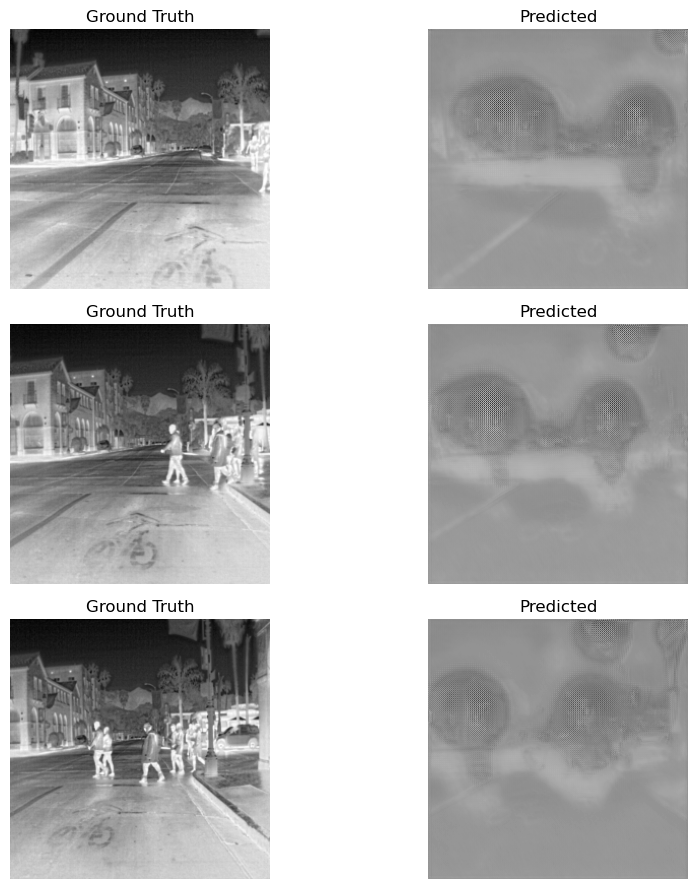

In [ ]:
# Visualize a few predictions vs. ground truth
num_show = 3
plt.figure(figsize=(10, num_show * 3))
for i in range(num_show):
    plt.subplot(num_show, 2, 2*i+1)
    plt.imshow(gts[i], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(num_show, 2, 2*i+2)
    plt.imshow(outputs[i], cmap='gray')
    plt.title('Predicted')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Plot training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [ ]:
# Save the final model (if not already done)
torch.save(model.state_dict(), 'unet_rgb2thermal_final.pth')
print("Final model saved as unet_rgb2thermal_final.pth")